In [148]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import plotly.figure_factory as ff
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from matplotlib.colors import LinearSegmentedColormap
from scipy.cluster.hierarchy import dendrogram
from shapely.geometry import LineString

In [149]:
theme = "flare_r"
num_colors = 20  # Number of distinct colors in the palette
palette = sns.color_palette(theme, num_colors)
sns.set_style("darkgrid", {'axes.spines.left': False,
                            'axes.spines.bottom': False,
                            'axes.spines.right': False,
                            'axes.spines.top': False
                            })
sns.set_context("talk")

In [150]:
%matplotlib inline

In [151]:
save_results_to = './figures/'

# Airfare Route Clustering

In [152]:
data = pd.read_excel("skyroute_case.xlsx")

In [153]:
display(data)

Year  quarter  citymarketid_1  citymarketid_2  \
0      2009        2           32467           34576   
1      2009        2           32211           32467   
2      2011        4           33044           33195   
3      2009        2           30977           34524   
4      2013        2           31650           33570   
...     ...      ...             ...             ...   
32006  2023        4           35412           30852   
32007  2023        4           35412           31703   
32008  2023        4           35412           32467   
32009  2023        4           35412           33195   
32010  2023        4           35412           34761   

                               city1                                  city2  \
0      Miami, FL (Metropolitan Area)                          Rochester, NY   
1                      Las Vegas, NV          Miami, FL (Metropolitan Area)   
2                     Louisville, KY          Tampa, FL (Metropolitan Area)   
3                        Chicago, IL                           Richmond, VA   
4           Minneapolis/St. Paul, MN                          San Diego, CA   
...                              ...                                    ...   
32006                  Knoxville, TN     Washington, DC (Metropolitan Area)   
32007                  Knoxville, TN  New York City, NY (Metropolitan Area)   
32008                  Knoxville, TN          Miami, FL (Metropolitan Area)   
32009                  Knoxville, TN          Tampa, FL (Metropolitan Area)   
32010                  Knoxville, TN                            Sanford, FL   

       nsmiles  passengers    fare carrier_lg  large_ms  fare_lg carrier_low  \
0         1204         203  151.46         FL    0.2900   131.05          FL   
1         2175        1224  200.95         AA    0.3200   227.52          NK   
2          727         294  174.63         WN    0.6600   173.66          DL   
3          642         347  169.72         UA    0.6100   170.57          AA   
4         1532         700  244.01         DL    0.4600   279.09          SY   
...        ...         ...     ...        ...       ...      ...         ...   
32006      464         339  227.32         AA    0.7207   218.04          AA   
32007      684         420  248.08         DL    0.4319   309.25          G4   
32008      724         347  180.17         G4    0.6374   116.00          G4   
32009      550         295  143.43         G4    0.8036    92.75          G4   
32010      511         309   93.24         G4    1.0000    93.24          G4   

        lf_ms  fare_low  table_1_flag  \
0      0.2900    131.05             1   
1      0.1300    134.62             1   
2      0.2100    166.94             1   
3      0.2500    159.66             1   
4      0.2200    189.26             1   
...       ...       ...           ...   
32006  0.7207    218.04            -1   
32007  0.2761    124.31            -1   
32008  0.6374    116.00            -1   
32009  0.8036     92.75            -1   
32010  1.0000     93.24            -1   

                                          Geocoded_City1  \
0      Miami, FL (Metropolitan Area)\n(44.977479, -93...   
1                Las Vegas, NV\n(36.169202, -115.140597)   
2                Louisville, KY\n(38.256078, -85.751569)   
3                   Chicago, IL\n(41.775002, -87.696388)   
4      Minneapolis/St. Paul, MN\n(44.977479, -93.264346)   
...                                                  ...   
32006                                                NaN   
32007                                                NaN   
32008                                                NaN   
32009                                                NaN   
32010                                                NaN   

                                          Geocoded_City2  
0                 Rochester, NY\n(43.155708, -77.612547)  
1      Miami, FL (Metropolitan Area)\n(44.977479, -93...  
2      Tampa, FL (Metropolitan Ar

In [154]:
data["quarter"] = data["quarter"].astype("category")
data["Year"] = data["Year"].astype("category")
data["citymarketid_1"] = data["citymarketid_1"].astype("category")
data["citymarketid_2"] = data["citymarketid_2"].astype("category")
data["carrier_lg"] = data["carrier_lg"].astype("category")
data["carrier_low"] = data["carrier_low"].astype("category")
data["table_1_flag"] = data["table_1_flag"].astype("category")

In [155]:
data.describe()

nsmiles    passengers          fare      large_ms       fare_lg  \
count  32011.000000  32011.000000  32011.000000  32011.000000  32011.000000   
mean    1068.311268    887.559401    212.009693      0.555537    216.127927   
std      604.905410   1384.519390     58.153440      0.179575     68.009885   
min      129.000000     80.000000     72.530000      0.150000     69.160000   
25%      597.000000    261.500000    169.500000      0.418200    167.090000   
50%      936.000000    447.000000    205.020000      0.532500    208.360000   
75%     1442.000000    922.500000    249.870000      0.675000    258.400000   
max     2724.000000  23884.000000    676.890000      1.000000    679.120000   

              lf_ms      fare_low  
count  32011.000000  32011.000000  
mean       0.326688    175.935450  
std        0.231840     57.857337  
min        0.010000     59.480000  
25%        0.150000    131.110000  
50%        0.260000    172.330000  
75%        0.449450    214.415000  
max        1.000000    669.740000

In [156]:
data.columns

Index(['Year', 'quarter', 'citymarketid_1', 'citymarketid_2', 'city1', 'city2',
       'nsmiles', 'passengers', 'fare', 'carrier_lg', 'large_ms', 'fare_lg',
       'carrier_low', 'lf_ms', 'fare_low', 'table_1_flag', 'Geocoded_City1',
       'Geocoded_City2'],
      dtype='object')

In [157]:
cities = {}
delete_rows = []

def cityValidator(index, city_id, city_name):
    if city_id in cities:
        if city_name != cities[city_id]:
            delete_rows.append(index)
    else:
        cities[city_id] = city_name

print("There were", len(cities), "unique cities in the data")

result = [cityValidator(row[0], row[1], row[2]) for row in zip(data.index, data['citymarketid_1'], data['city1'])]
result = [cityValidator(row[0], row[1], row[2]) for row in zip(data.index, data['citymarketid_2'], data['city2'])]
print("There were", len(delete_rows), "items that had invalid city id data")

There were 0 unique cities in the data
There were 0 items that had invalid city id data


In [158]:
delete_rows = []

def marketValidator(index, carrier_lg, carrier_low, large_ms, lf_ms):
    if carrier_lg != carrier_low:
        if large_ms + lf_ms >= 1:
            delete_rows.append(index)


result = [marketValidator(row[0], row[1], row[2], row[3],row[4]) for row in zip(data.index, data['carrier_lg'], data['carrier_low'], data['large_ms'], data['lf_ms'])]
print("There were", len(delete_rows), "items that had invalid market share data")

There were 16 items that had invalid market share data


In [159]:
valid_data = data.drop(delete_rows)

In [160]:
check_nan_df = valid_data.iloc[:,:-2]
print(check_nan_df.columns)
check_nan_df.isna().any()

Index(['Year', 'quarter', 'citymarketid_1', 'citymarketid_2', 'city1', 'city2',
       'nsmiles', 'passengers', 'fare', 'carrier_lg', 'large_ms', 'fare_lg',
       'carrier_low', 'lf_ms', 'fare_low', 'table_1_flag'],
      dtype='object')


Year              False
quarter           False
citymarketid_1    False
citymarketid_2    False
city1             False
city2             False
nsmiles           False
passengers        False
fare              False
carrier_lg        False
large_ms          False
fare_lg           False
carrier_low       False
lf_ms             False
fare_low          False
table_1_flag      False
dtype: bool

Create  a dictionary of all unique cities

In [161]:
city1 = valid_data.loc[:, ["citymarketid_1", "city1"]].rename(columns={"citymarketid_1":"citymarket_id", "city1":"city"})
city2 = valid_data.loc[:, ["citymarketid_2", "city2"]].rename(columns={"citymarketid_2":"citymarket_id", "city2":"city"})

cities_df = pd.concat([city1, city2]).drop_duplicates().reset_index(drop=True)

print("City IDs has duplicates:", cities_df.duplicated().any())

cities_df

City IDs has duplicates: False


citymarket_id                           city
0            32467  Miami, FL (Metropolitan Area)
1            32211                  Las Vegas, NV
2            33044                 Louisville, KY
3            30977                    Chicago, IL
4            31650       Minneapolis/St. Paul, MN
..             ...                            ...
158          34457                 Rapid City, SD
159          35165                     Toledo, OH
160          34952                Springfield, IL
161          35380              Traverse City, MI
162          33933                  Worcester, MA

[163 rows x 2 columns]

Create a list of cities that have coordinate data

In [162]:
geo1 = valid_data.loc[:, ["citymarketid_1", "Geocoded_City1"]].rename(columns={"citymarketid_1":"citymarket_id", "Geocoded_City1":"Geocoded_City"})
geo2 = valid_data.loc[:, ["citymarketid_2", "Geocoded_City2"]].rename(columns={"citymarketid_2":"citymarket_id", "Geocoded_City2":"Geocoded_City"})

geo_df = pd.concat([geo1, geo2])

In [163]:
geo_df[["lat","long"]] = geo_df['Geocoded_City'].str.extract(r'(-?\d+\.\d+), (-?\d+\.\d+)')
geo_df.drop("Geocoded_City", axis="columns", inplace=True)

In [164]:
geo_df = geo_df.dropna(subset=["lat", "long"])
geo_df = geo_df.drop_duplicates(subset="citymarket_id")
geo_df = geo_df.reset_index(drop=True)

na_count = geo_df[["lat", "long"]].isna().sum()
print(f"Geocoded City has {na_count} NaN:")

geo_df

Geocoded City has lat     0
long    0
dtype: int64 NaN:


citymarket_id        lat         long
0            32467  44.977479   -93.264346
1            32211  36.169202  -115.140597
2            33044  38.256078   -85.751569
3            30977  41.775002   -87.696388
4            31650  44.977479   -93.264346
..             ...        ...          ...
142          34783   39.79936   -89.643624
143          34716  37.957541  -121.292451
144          30285   37.28225  -107.877762
145          34082  40.881194   -88.628678
146          34314  41.824461   -71.412747

[147 rows x 3 columns]

In [165]:
city_geo_df = cities_df.merge(geo_df, on="citymarket_id")
city_geo_df.drop_duplicates(subset="citymarket_id", inplace=True)
city_geo_df

citymarket_id                           city        lat         long
0            32467  Miami, FL (Metropolitan Area)  44.977479   -93.264346
1            32211                  Las Vegas, NV  36.169202  -115.140597
2            33044                 Louisville, KY  38.256078   -85.751569
3            30977                    Chicago, IL  41.775002   -87.696388
4            31650       Minneapolis/St. Paul, MN  44.977479   -93.264346
..             ...                            ...        ...          ...
142          32896                    Lubbock, TX  41.181125   -96.030508
143          32323                 Wilmington, NC  39.744432     -75.5451
144          34716                   Stockton, CA  37.957541  -121.292451
145          34314                      Provo, UT  41.824461   -71.412747
146          30285                    Durango, CO   37.28225  -107.877762

[147 rows x 4 columns]

Let's find what cities are missing the coordinates

In [166]:
diff_rows = pd.merge(city_geo_df, cities_df, how='outer', indicator=True).query('_merge == "right_only"').drop(columns='_merge').reset_index(drop=True)
diff_rows

citymarket_id                                 city  lat long
0           30157                    Eureka/Arcata, CA  NaN  NaN
1           30676                       Belleville, IL  NaN  NaN
2           30990                  Charlottesville, VA  NaN  NaN
3           32124                      Hilton Head, SC  NaN  NaN
4           32223                          Ashland, WV  NaN  NaN
5           32244                        New Haven, CT  NaN  NaN
6           32280                      Idaho Falls, ID  NaN  NaN
7           32556                        St. Cloud, MN  NaN  NaN
8           33367  Quad Cities, IL (Metropolitan Area)  NaN  NaN
9           33502                   Montrose/Delta, CO  NaN  NaN
10          33933                        Worcester, MA  NaN  NaN
11          34457                       Rapid City, SD  NaN  NaN
12          34699                Steamboat Springs, CO  NaN  NaN
13          34952                      Springfield, IL  NaN  NaN
14          35165                           Toledo, OH  NaN  NaN
15          35380                    Traverse City, MI  NaN  NaN

In [167]:
import requests
import time

def request_coords(city):
    city = city.replace("(Metropolitan Area)", "")
    city = city.replace(" ", "+")
    print(city)
    query = "search?q=" + city
    base_url="https://nominatim.openstreetmap.org/"
    output_format="&format=jsonv2&limit=1"
    # example url: https://nominatim.openstreetmap.org/search?q=Berlin&format=json
    url = base_url + query + output_format
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8',
        'Accept-Encoding': 'gzip, deflate, br',
        'Accept-Language': 'en-US,en;q=0.9',
        'Referer': 'https://nominatim.org/'
    }
    try:
        # pass
        print(url)
        response = requests.get(url, headers=headers)
        print(response)
        if response.status_code == 200:
            data = response.json()
            print(data)
            # get the first location data
            if data[0]:
                return data[0]["lon"], data[0]["lat"]
            else:
                raise "No Data recieved"
        response.raise_for_status()
    except Exception as e:
        print(e)

for i in range(len(diff_rows)):
    city = diff_rows.loc[i, "city"]
    lon, lat = request_coords(city)
    lat = str(round(float(lat),6))
    lon = str(round(float(lon),6))
    diff_rows.loc[i, "long"] = lon
    diff_rows.loc[i, "lat"] = lat
    time.sleep(2)                

Eureka/Arcata,+CA
https://nominatim.openstreetmap.org/search?q=Eureka/Arcata,+CA&format=jsonv2&limit=1
<Response [200]>
[{'place_id': 312117174, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 44487064, 'lat': '40.9763645', 'lon': '-124.10842589937442', 'category': 'aeroway', 'type': 'aerodrome', 'place_rank': 30, 'importance': 0.3300696689354899, 'addresstype': 'aeroway', 'name': 'California Redwood Coast - Humboldt County Airport', 'display_name': 'California Redwood Coast - Humboldt County Airport, Airport Loop Road, McKinleyville, Humboldt County, California, 95519, United States', 'boundingbox': ['40.9642336', '40.9884689', '-124.1161671', '-124.1007444']}]
Belleville,+IL
https://nominatim.openstreetmap.org/search?q=Belleville,+IL&format=jsonv2&limit=1
<Response [200]>
[{'place_id': 323581394, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 125728,

In [168]:
diff_rows

citymarket_id                                 city        lat         long
0           30157                    Eureka/Arcata, CA  40.976365  -124.108426
1           30676                       Belleville, IL  38.513581   -89.984163
2           30990                  Charlottesville, VA  38.029306   -78.476678
3           32124                      Hilton Head, SC  32.161849   -80.751262
4           32223                          Ashland, WV  37.408449   -81.352602
5           32244                        New Haven, CT  41.308214   -72.925052
6           32280                      Idaho Falls, ID  43.488791   -112.03628
7           32556                        St. Cloud, MN  45.561608     -94.1642
8           33367  Quad Cities, IL (Metropolitan Area)   41.51392   -90.492917
9           33502                   Montrose/Delta, CO  38.421144  -107.891017
10          33933                        Worcester, MA  42.262562   -71.801888
11          34457                       Rapid City, SD  44.080604  -103.228023
12          34699                Steamboat Springs, CO    40.4848  -106.831735
13          34952                      Springfield, IL  39.799017   -89.643957
14          35165                           Toledo, OH  41.652914   -83.537817
15          35380                    Traverse City, MI  44.760648   -85.616598

clean the geocoded cities and split into two seperate lat and long columns

In [169]:
city_geo_df = pd.concat([city_geo_df, diff_rows]).reset_index(drop=True)
city_geo_df

citymarket_id                           city        lat         long
0            32467  Miami, FL (Metropolitan Area)  44.977479   -93.264346
1            32211                  Las Vegas, NV  36.169202  -115.140597
2            33044                 Louisville, KY  38.256078   -85.751569
3            30977                    Chicago, IL  41.775002   -87.696388
4            31650       Minneapolis/St. Paul, MN  44.977479   -93.264346
..             ...                            ...        ...          ...
158          34457                 Rapid City, SD  44.080604  -103.228023
159          34699          Steamboat Springs, CO    40.4848  -106.831735
160          34952                Springfield, IL  39.799017   -89.643957
161          35165                     Toledo, OH  41.652914   -83.537817
162          35380              Traverse City, MI  44.760648   -85.616598

[163 rows x 4 columns]

Finalized City Dictionary dataframe

In [170]:
city_geo_df

citymarket_id                           city        lat         long
0            32467  Miami, FL (Metropolitan Area)  44.977479   -93.264346
1            32211                  Las Vegas, NV  36.169202  -115.140597
2            33044                 Louisville, KY  38.256078   -85.751569
3            30977                    Chicago, IL  41.775002   -87.696388
4            31650       Minneapolis/St. Paul, MN  44.977479   -93.264346
..             ...                            ...        ...          ...
158          34457                 Rapid City, SD  44.080604  -103.228023
159          34699          Steamboat Springs, CO    40.4848  -106.831735
160          34952                Springfield, IL  39.799017   -89.643957
161          35165                     Toledo, OH  41.652914   -83.537817
162          35380              Traverse City, MI  44.760648   -85.616598

[163 rows x 4 columns]

In [171]:
city_geo_df.dtypes

citymarket_id     int64
city             object
lat              object
long             object
dtype: object

In [172]:
city_geo_df["lat"] = city_geo_df["lat"].astype(float)
city_geo_df["long"] = city_geo_df["long"].astype(float)

In [173]:
city_geo_df.dtypes

citymarket_id      int64
city              object
lat              float64
long             float64
dtype: object

Check if any cities are outside the bounds of the continental US, Alaska, and Hawaii

In [174]:
# 'latitude': (18, 71),  # Min and max latitude
# 'longitude': (-179, -66)  # Min and max longitude

city_geo_df.loc[
    (city_geo_df["lat"] < 18) | (city_geo_df["lat"] > 71) | 
    (city_geo_df["long"] < -179) | (city_geo_df["long"] > -66)
]

Empty DataFrame
Columns: [citymarket_id, city, lat, long]
Index: []

Warning! In Place Drops: rerun the code sequentially if it doesnt work

In [175]:
valid_data.drop(["Geocoded_City1", "Geocoded_City2"], axis="columns", inplace=True)

In [176]:
city_geo_df.drop("city", axis="columns", inplace=True)

In [177]:
cleaned_data = pd.merge(valid_data, city_geo_df, left_on='citymarketid_1', right_on='citymarket_id', how='left')
cleaned_data = cleaned_data.rename(columns={'lat': 'city1_lat', 'long': 'city1_long'})
cleaned_data = pd.merge(cleaned_data, city_geo_df, left_on='citymarketid_2', right_on='citymarket_id', how='left')
cleaned_data = cleaned_data.rename(columns={'lat': 'city2_lat', 'long': 'city2_long'})
cleaned_data = cleaned_data.drop(columns=['citymarket_id_x', 'citymarket_id_y'])
cleaned_data

Year quarter  citymarketid_1  citymarketid_2  \
0      2009       2           32467           34576   
1      2009       2           32211           32467   
2      2011       4           33044           33195   
3      2009       2           30977           34524   
4      2013       2           31650           33570   
...     ...     ...             ...             ...   
31990  2023       4           35412           30852   
31991  2023       4           35412           31703   
31992  2023       4           35412           32467   
31993  2023       4           35412           33195   
31994  2023       4           35412           34761   

                               city1                                  city2  \
0      Miami, FL (Metropolitan Area)                          Rochester, NY   
1                      Las Vegas, NV          Miami, FL (Metropolitan Area)   
2                     Louisville, KY          Tampa, FL (Metropolitan Area)   
3                        Chicago, IL                           Richmond, VA   
4           Minneapolis/St. Paul, MN                          San Diego, CA   
...                              ...                                    ...   
31990                  Knoxville, TN     Washington, DC (Metropolitan Area)   
31991                  Knoxville, TN  New York City, NY (Metropolitan Area)   
31992                  Knoxville, TN          Miami, FL (Metropolitan Area)   
31993                  Knoxville, TN          Tampa, FL (Metropolitan Area)   
31994                  Knoxville, TN                            Sanford, FL   

       nsmiles  passengers    fare carrier_lg  large_ms  fare_lg carrier_low  \
0         1204         203  151.46         FL    0.2900   131.05          FL   
1         2175        1224  200.95         AA    0.3200   227.52          NK   
2          727         294  174.63         WN    0.6600   173.66          DL   
3          642         347  169.72         UA    0.6100   170.57          AA   
4         1532         700  244.01         DL    0.4600   279.09          SY   
...        ...         ...     ...        ...       ...      ...         ...   
31990      464         339  227.32         AA    0.7207   218.04          AA   
31991      684         420  248.08         DL    0.4319   309.25          G4   
31992      724         347  180.17         G4    0.6374   116.00          G4   
31993      550         295  143.43         G4    0.8036    92.75          G4   
31994      511         309   93.24         G4    1.0000    93.24          G4   

        lf_ms  fare_low table_1_flag  city1_lat  city1_long  city2_lat  \
0      0.2900    131.05            1  44.977479  -93.264346  43.155708   
1      0.1300    134.62            1  36.169202 -115.140597  44.977479   
2      0.2100    166.94            1  38.256078  -85.751569  37.860600   
3      0.2500    159.66            1  41.775002  -87.696388  37.540759   
4      0.2200    189.26            1  44.977479  -93.264346  32.715760   
...       ...       ...          ...        ...         ...        ...   
31990  0.7207    218.04           -1  35.962631  -83.916677  38.892062   
31991  0.2761    124.31           -1  35.962631  -83.916677  40.123164   
31992  0.6374    116.00           -1  35.962631  -83.916677  44.977479   
31993  0.8036     92.75           -1  35.962631  -83.916677  37.860600   
31994  1.0000     93.24           -1  35.962631  -83.916677  37.780080   

       city2_long  
0      -77.612547  
1      -93.264346  
2      -78.804199  
3      -77.433932  
4     -117.163817  
...           ...  
31990  -77.019912  
31991  -75.333718  
31992  -93.264346  
31993  -78.804199  
31994 -122.420168  

[31995 rows x 20 columns]

In [178]:
cleaned_data.columns

Index(['Year', 'quarter', 'citymarketid_1', 'citymarketid_2', 'city1', 'city2',
       'nsmiles', 'passengers', 'fare', 'carrier_lg', 'large_ms', 'fare_lg',
       'carrier_low', 'lf_ms', 'fare_low', 'table_1_flag', 'city1_lat',
       'city1_long', 'city2_lat', 'city2_long'],
      dtype='object')

In [179]:
cleaned_data[cleaned_data.isna().any(axis=1)]

Empty DataFrame
Columns: [Year, quarter, citymarketid_1, citymarketid_2, city1, city2, nsmiles, passengers, fare, carrier_lg, large_ms, fare_lg, carrier_low, lf_ms, fare_low, table_1_flag, city1_lat, city1_long, city2_lat, city2_long]
Index: []

## Visualization

In [180]:
import geopandas as gpd
from geodatasets import get_path
import matplotlib.colors as mcolors 
import matplotlib.cm as cm

In [181]:
city_pairs_df = cleaned_data.copy()
# Create LineString geometries for each city pair
city_pairs_df['geometry'] = city_pairs_df.apply(
    lambda row: LineString([(row['city1_long'], row['city1_lat']), (row['city2_long'], row['city2_lat'])]), axis=1
)
city_pairs_gdf = gpd.GeoDataFrame(city_pairs_df, geometry='geometry', crs="EPSG:4326")


/var/folders/jp/kfj824gx65b8nff1zyzy14wh0000gn/T/ipykernel_20163/1911661904.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  sm = plt.cm.ScalarMappable(cmap=cm.get_cmap(theme, num_colors), norm=norm)


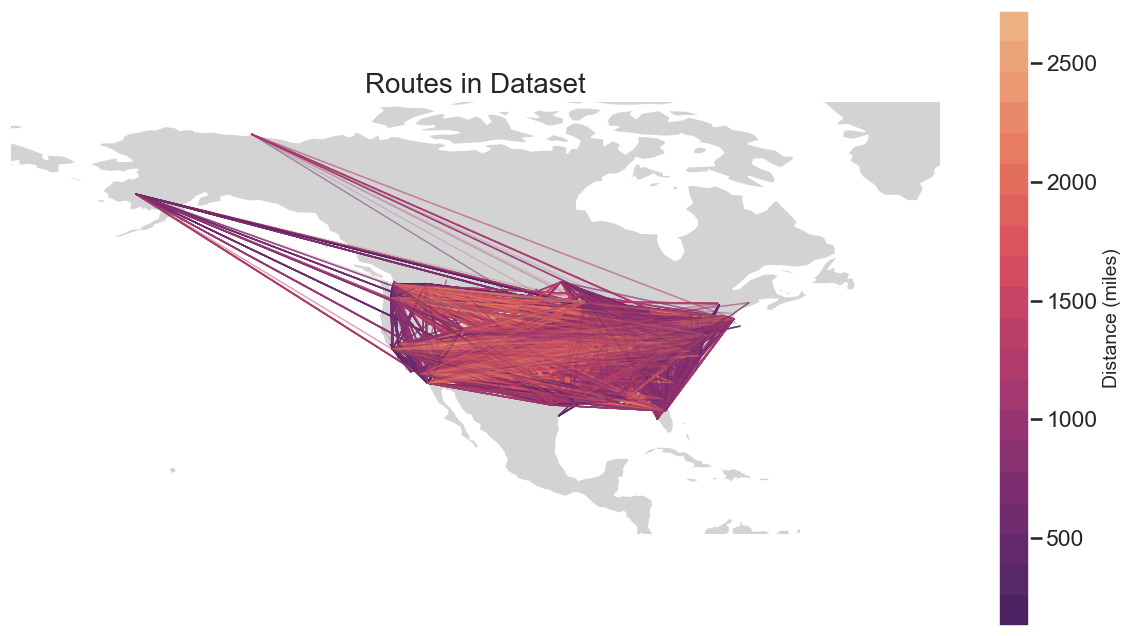

In [182]:
world = gpd.read_file(get_path("naturalearth.land"))

# Normalize the lengths to the range [0, num_colors-1] to map to palette
norm = mcolors.Normalize(vmin=city_pairs_gdf['nsmiles'].min(), vmax=city_pairs_gdf['nsmiles'].max())

fig, ax = plt.subplots(figsize=(15, 8))
world.plot(ax=ax, color='lightgrey', edgecolor='white')

# Plot each line with a color based on its normalized length
for i, row in city_pairs_gdf.iterrows():
    # Get normalized length value mapped to an index in the palette
    color_idx = int(norm(row['nsmiles']) * (num_colors - 1))
    color = palette[color_idx]
    
    # Plot the line with the corresponding color
    ax.plot(*row['geometry'].xy, color=color, linewidth=1, alpha=0.2)

# Create a colorbar
sm = plt.cm.ScalarMappable(cmap=cm.get_cmap(theme, num_colors), norm=norm)
sm.set_array([])  # Only needed for older versions of Matplotlib
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Distance (miles)', fontsize=14)

# Define the bounding box for North America
xlim = (-180, -40)  # Longitude limits
ylim = (10, 75)     # Latitude limits

# Set the limits for North America
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_axis_off()  # Hides the axis

plt.title("Routes in Dataset", fontsize=20)

fig.savefig(f"./{save_results_to}/allroutes.png", dpi=300, transparent=True)

plt.show()

In [183]:
city_gdf = gpd.GeoDataFrame(cities_df, geometry=gpd.points_from_xy(city_geo_df.long, city_geo_df.lat), crs="EPSG:4326")

In [184]:
city_gdf

citymarket_id                           city                    geometry
0            32467  Miami, FL (Metropolitan Area)  POINT (-93.26435 44.97748)
1            32211                  Las Vegas, NV   POINT (-115.1406 36.1692)
2            33044                 Louisville, KY  POINT (-85.75157 38.25608)
3            30977                    Chicago, IL    POINT (-87.69639 41.775)
4            31650       Minneapolis/St. Paul, MN  POINT (-93.26435 44.97748)
..             ...                            ...                         ...
158          34457                 Rapid City, SD  POINT (-103.22802 44.0806)
159          35165                     Toledo, OH  POINT (-106.83174 40.4848)
160          34952                Springfield, IL  POINT (-89.64396 39.79902)
161          35380              Traverse City, MI  POINT (-83.53782 41.65291)
162          33933                  Worcester, MA   POINT (-85.6166 44.76065)

[163 rows x 3 columns]

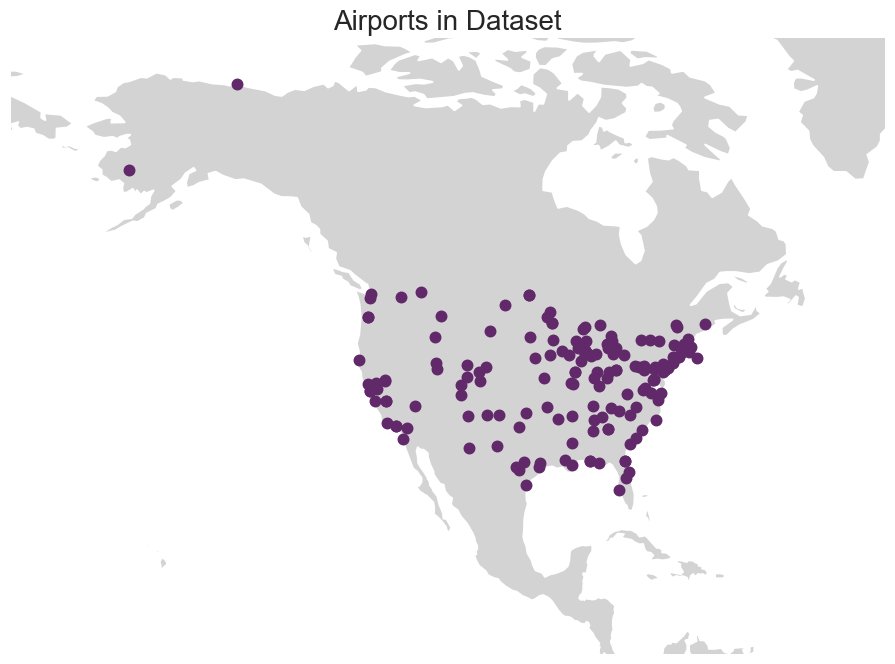

In [185]:
world = gpd.read_file(get_path("naturalearth.land"))

fig, ax = plt.subplots(figsize=(15, 8))
world.plot(ax=ax, color='lightgrey', edgecolor='white')

city_gdf.plot(ax=ax, color=palette[1], markersize=50, marker='o', label='Cities')

# # Define the bounding box for North America
xlim = (-180, -40)  # Longitude limits
ylim = (10, 75)     # Latitude limits

# # Set the limits for North America
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_axis_off()  # Hides the axis
plt.title("Airports in Dataset", fontsize=20)
fig.savefig(f"./{save_results_to}/airports.png", dpi=300, transparent=True)

plt.show()


## Data Cleaning

In [186]:
print(cleaned_data.dtypes)

Year              category
quarter           category
citymarketid_1       int64
citymarketid_2       int64
city1               object
city2               object
nsmiles              int64
passengers           int64
fare               float64
carrier_lg        category
large_ms           float64
fare_lg            float64
carrier_low       category
lf_ms              float64
fare_low           float64
table_1_flag      category
city1_lat          float64
city1_long         float64
city2_lat          float64
city2_long         float64
dtype: object


In [187]:
cleaned_data["citymarketid_1"] = cleaned_data["citymarketid_1"].astype("category")
cleaned_data["citymarketid_2"] = cleaned_data["citymarketid_2"].astype("category")
cleaned_data["city1_lat"] = cleaned_data["city1_lat"].astype("float64")
cleaned_data["city1_long"] = cleaned_data["city1_long"].astype("float64")
cleaned_data["city2_lat"] = cleaned_data["city2_lat"].astype("float64")
cleaned_data["city2_long"] = cleaned_data["city2_long"].astype("float64")

In [188]:
model_data = cleaned_data.drop(["Year", "city1", "city2", "quarter", "citymarketid_1", "citymarketid_2", "city1_lat", "city1_long", "city2_lat", "city2_long", "carrier_lg", "carrier_low", "table_1_flag"], axis="columns")
# "city1_lat", "city1_long", "city2_lat", "city2_long"

In [189]:
print(model_data.dtypes)

nsmiles         int64
passengers      int64
fare          float64
large_ms      float64
fare_lg       float64
lf_ms         float64
fare_low      float64
dtype: object


In [190]:
X = pd.get_dummies(model_data)

In [191]:
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)
X_normalized =  pd.DataFrame(X_normalized, columns=X.columns, index=X.index)

In [192]:
X_normalized

nsmiles  passengers      fare  large_ms   fare_lg     lf_ms  fare_low
0      0.414258    0.005167  0.130601  0.164706  0.101466  0.282828  0.117278
1      0.788439    0.048059  0.212489  0.200000  0.259624  0.121212  0.123128
2      0.230443    0.008990  0.168939  0.600000  0.171323  0.202020  0.176089
3      0.197688    0.011217  0.160815  0.541176  0.166257  0.242424  0.164160
4      0.540655    0.026046  0.283738  0.364706  0.344170  0.212121  0.212663
...         ...         ...       ...       ...       ...       ...       ...
31990  0.129094    0.010881  0.256122  0.671412  0.244082  0.717879  0.259824
31991  0.213873    0.014283  0.290473  0.331647  0.393616  0.268788  0.106233
31992  0.229287    0.011217  0.178106  0.573412  0.076792  0.633737  0.092616
31993  0.162235    0.009032  0.117314  0.768941  0.038675  0.801616  0.054518
31994  0.147206    0.009620  0.034268  1.000000  0.039478  1.000000  0.055321

[31995 rows x 7 columns]

## Create Model

### DBSCAN

In [193]:
dbscan = DBSCAN(eps=0.1)

In [194]:
dbscan.fit(X_normalized)

DBSCAN(eps=0.1)

In [195]:
labels = dbscan.labels_

In [196]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 18
Estimated number of noise points: 384


In [197]:
dbscan_df = cleaned_data.copy()
dbscan_df["cluster"] = dbscan.labels_
dbscan_df

Year quarter citymarketid_1 citymarketid_2  \
0      2009       2          32467          34576   
1      2009       2          32211          32467   
2      2011       4          33044          33195   
3      2009       2          30977          34524   
4      2013       2          31650          33570   
...     ...     ...            ...            ...   
31990  2023       4          35412          30852   
31991  2023       4          35412          31703   
31992  2023       4          35412          32467   
31993  2023       4          35412          33195   
31994  2023       4          35412          34761   

                               city1                                  city2  \
0      Miami, FL (Metropolitan Area)                          Rochester, NY   
1                      Las Vegas, NV          Miami, FL (Metropolitan Area)   
2                     Louisville, KY          Tampa, FL (Metropolitan Area)   
3                        Chicago, IL                           Richmond, VA   
4           Minneapolis/St. Paul, MN                          San Diego, CA   
...                              ...                                    ...   
31990                  Knoxville, TN     Washington, DC (Metropolitan Area)   
31991                  Knoxville, TN  New York City, NY (Metropolitan Area)   
31992                  Knoxville, TN          Miami, FL (Metropolitan Area)   
31993                  Knoxville, TN          Tampa, FL (Metropolitan Area)   
31994                  Knoxville, TN                            Sanford, FL   

       nsmiles  passengers    fare carrier_lg  ...  fare_lg  carrier_low  \
0         1204         203  151.46         FL  ...   131.05           FL   
1         2175        1224  200.95         AA  ...   227.52           NK   
2          727         294  174.63         WN  ...   173.66           DL   
3          642         347  169.72         UA  ...   170.57           AA   
4         1532         700  244.01         DL  ...   279.09           SY   
...        ...         ...     ...        ...  ...      ...          ...   
31990      464         339  227.32         AA  ...   218.04           AA   
31991      684         420  248.08         DL  ...   309.25           G4   
31992      724         347  180.17         G4  ...   116.00           G4   
31993      550         295  143.43         G4  ...    92.75           G4   
31994      511         309   93.24         G4  ...    93.24           G4   

        lf_ms  fare_low  table_1_flag  city1_lat  city1_long  city2_lat  \
0      0.2900    131.05             1  44.977479  -93.264346  43.155708   
1      0.1300    134.62             1  36.169202 -115.140597  44.977479   
2      0.2100    166.94             1  38.256078  -85.751569  37.860600   
3      0.2500    159.66             1  41.775002  -87.696388  37.540759   
4      0.2200    189.26             1  44.977479  -93.264346  32.715760   
...       ...       ...           ...        ...         ...        ...   
31990  0.7207    218.04            -1  35.962631  -83.916677  38.892062   
31991  0.2761    124.31            -1  35.962631  -83.916677  40.123164   
31992  0.6374    116.00            -1  35.962631  -83.916677  44.977479   
31993  0.8036     92.75            -1  35.962631  -83.916677  37.860600   
31994  1.0000     93.24            -1  35.962631  -83.916677  37.780080   

       city2_long  cluster  
0      -77.612547        0  
1      -93.264346        0  
2      -78.804199        0  
3      -77.433932        0  
4     -117.163817        0  
...           ...      ...  
31990  -77.019912        0  
31991  -75.333718        0  
31992  -93.264346        0  
31993  -78.804199        0  
31994 -122.420168        0  

[31995 rows x 21 columns]

In [198]:
dbscan_df["cluster"].value_counts()

cluster
 0     31432
-1       384
 2        28
 4        25
 3        22
 8        19
 13       12
 5        12
 1        10
 11        7
 9         7
 15        6
 12        5
 10        5
 6         5
 17        5
 7         5
 16        4
 14        2
Name: count, dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

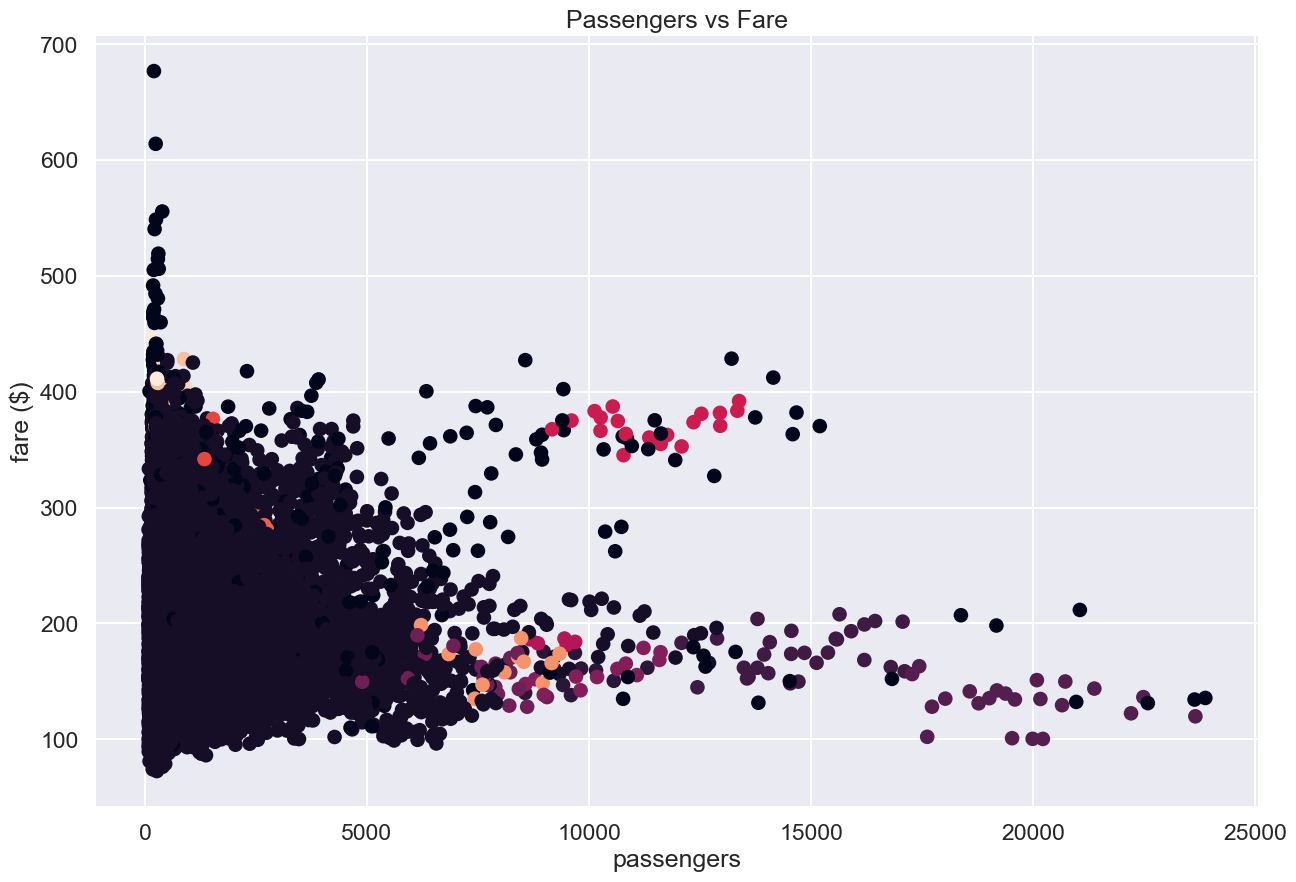

In [199]:
fig, ax = plt.subplots(figsize=(15, 10))

ax = ax.scatter(x=dbscan_df["passengers"], y=dbscan_df["fare"], c=dbscan_df["cluster"])
plt.title("Passengers vs Fare")
plt.xlabel("passengers")
plt.ylabel("fare ($)")

fig.savefig(f"./{save_results_to}/dbscan1passfare.png", dpi=300, transparent=True)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

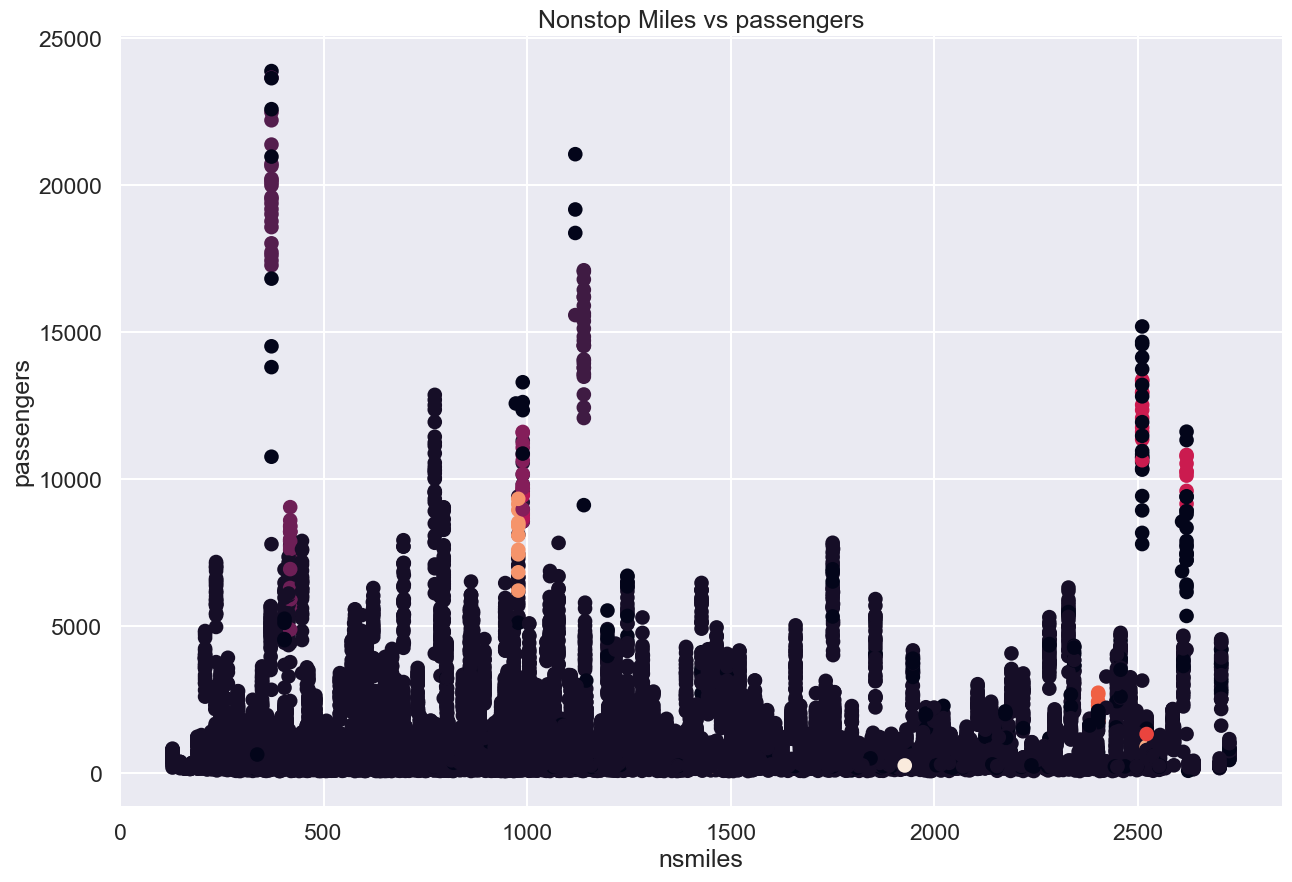

In [200]:
fig, ax = plt.subplots(figsize=(15, 10))

ax = ax.scatter(x=dbscan_df["nsmiles"], y=dbscan_df["passengers"], c=dbscan_df["cluster"])
plt.title("Nonstop Miles vs passengers")
plt.xlabel("nsmiles")
plt.ylabel("passengers")
fig.savefig(f"./{save_results_to}/dbscan1milespass.png", dpi=300, transparent=True)

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

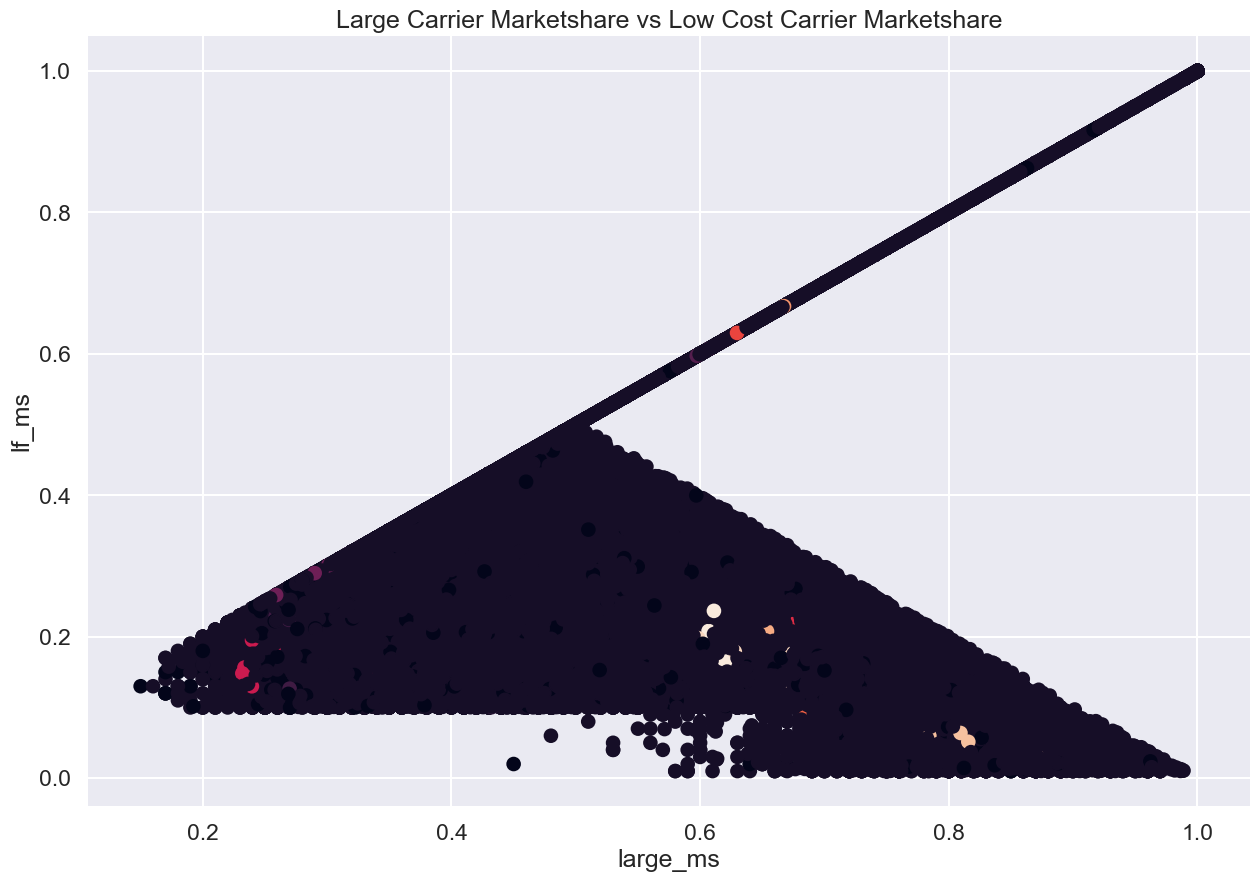

In [201]:
fig, ax = plt.subplots(figsize=(15, 10))

ax = ax.scatter(x=dbscan_df["large_ms"], y=dbscan_df["lf_ms"], c=dbscan_df["cluster"])
plt.title("Large Carrier Marketshare vs Low Cost Carrier Marketshare")
plt.xlabel("large_ms")
plt.ylabel("lf_ms")
fig.savefig(f"./{save_results_to}/dbscan1ms.png", dpi=300, transparent=True)
plt.show

In [202]:
city_gdf = gpd.GeoDataFrame(dbscan_df, geometry=gpd.points_from_xy(dbscan_df.city1_long, dbscan_df.city1_lat), crs="EPSG:4326")

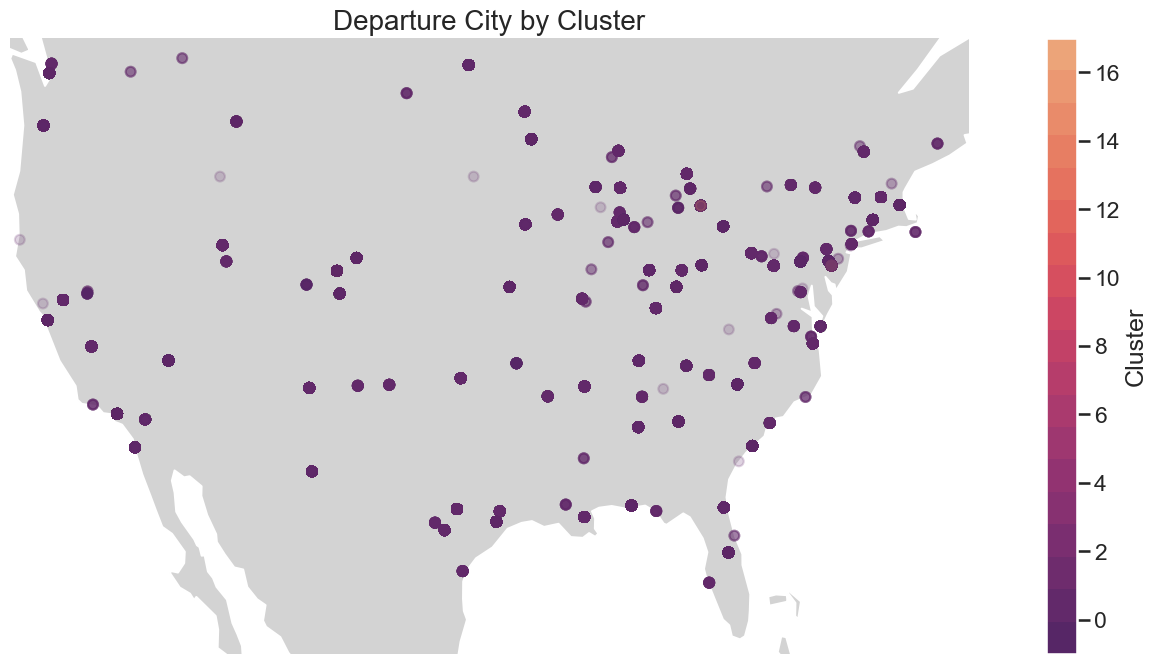

In [203]:
# Load data
world = gpd.read_file(get_path("naturalearth.land"))
# Assuming city_gdf is your GeoDataFrame with city data and cluster information

# Create a custom colormap using the Seaborn palette
n_clusters = city_gdf['cluster'].nunique()
colors = sns.color_palette(theme, n_colors=n_clusters)
cmap = LinearSegmentedColormap.from_list("custom", colors, N=n_clusters)

# Create the plot
fig, ax = plt.subplots(figsize=(20, 8))

# Plot the world map
world.plot(ax=ax, color='lightgrey', edgecolor='white')

# Plot cities with colors according to cluster
scatter = city_gdf.plot(ax=ax, column='cluster', cmap=cmap, 
                        markersize=50, marker='o', legend=True,
                        legend_kwds={'label': 'Cluster', 'orientation': 'vertical'},
                        alpha=0.2)

# Define the bounding box for North America
xlim = (-124.7, -66.9)  # Longitude limits
ylim = (24.5, 49)  # Latitude limits

# Set the limits for North America
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_axis_off()  # Hides the axis

plt.title("Departure City by Cluster", fontsize=20)

# Adjust the legend position
leg = ax.get_legend()
fig.savefig(f"./{save_results_to}/dbscan1city1cluster.png", dpi=300, transparent=True)
plt.show()


In [204]:
city_gdf = gpd.GeoDataFrame(dbscan_df, geometry=gpd.points_from_xy(dbscan_df.city2_long, dbscan_df.city2_lat), crs="EPSG:4326")

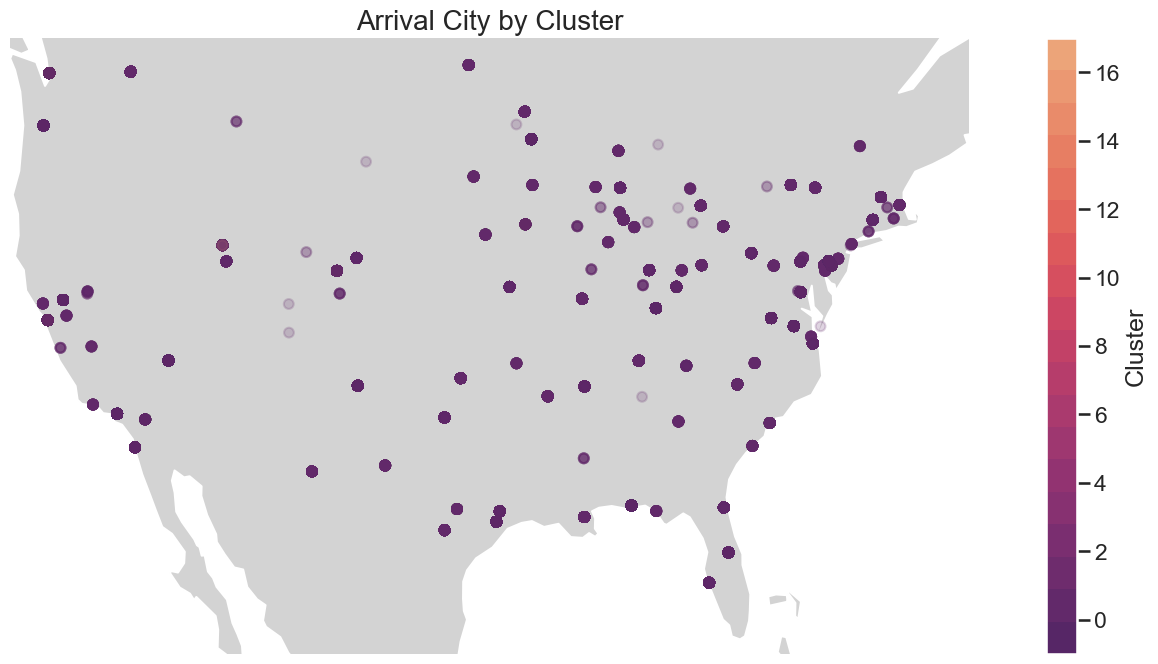

In [205]:
# Load data
world = gpd.read_file(get_path("naturalearth.land"))
# Assuming city_gdf is your GeoDataFrame with city data and cluster information

# Create a custom colormap using the Seaborn palette
n_clusters = city_gdf['cluster'].nunique()
colors = sns.color_palette(theme, n_colors=n_clusters)
cmap = LinearSegmentedColormap.from_list("custom", colors, N=n_clusters)

# Create the plot
fig, ax = plt.subplots(figsize=(20, 8))

# Plot the world map
world.plot(ax=ax, color='lightgrey', edgecolor='white')

# Plot cities with colors according to cluster
scatter = city_gdf.plot(ax=ax, column='cluster', cmap=cmap, 
                        markersize=50, marker='o', legend=True,
                        legend_kwds={'label': 'Cluster', 'orientation': 'vertical'},
                        alpha=0.2)

# Define the bounding box for North America
xlim = (-124.7, -66.9)  # Longitude limits
ylim = (24.5, 49)  # Latitude limits

# Set the limits for North America
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_axis_off()  # Hides the axis

plt.title("Arrival City by Cluster", fontsize=20)

# Adjust the legend position
leg = ax.get_legend()

fig.savefig(f"./{save_results_to}/dbscan1city2cluster.png", dpi=300, transparent=True)
plt.show()

In [206]:
silhouette_avg = silhouette_score(X_normalized, dbscan.labels_)
print(f"The average silhouette score is: {silhouette_avg}")

The average silhouette score is: -0.29452583790464176


In [207]:
db_score = davies_bouldin_score(X_normalized, dbscan.labels_)
print(f"The Davies-Bouldin score is: {db_score}")

The Davies-Bouldin score is: 1.3005239644637958


### Agglomerative Clustering

In [208]:
agg = AgglomerativeClustering(n_clusters=4, compute_distances=True)

In [209]:
agg.fit(X_normalized)

AgglomerativeClustering(compute_distances=True, n_clusters=4)

In [210]:
agg.n_clusters_

4

In [211]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


<function matplotlib.pyplot.show(close=None, block=None)>

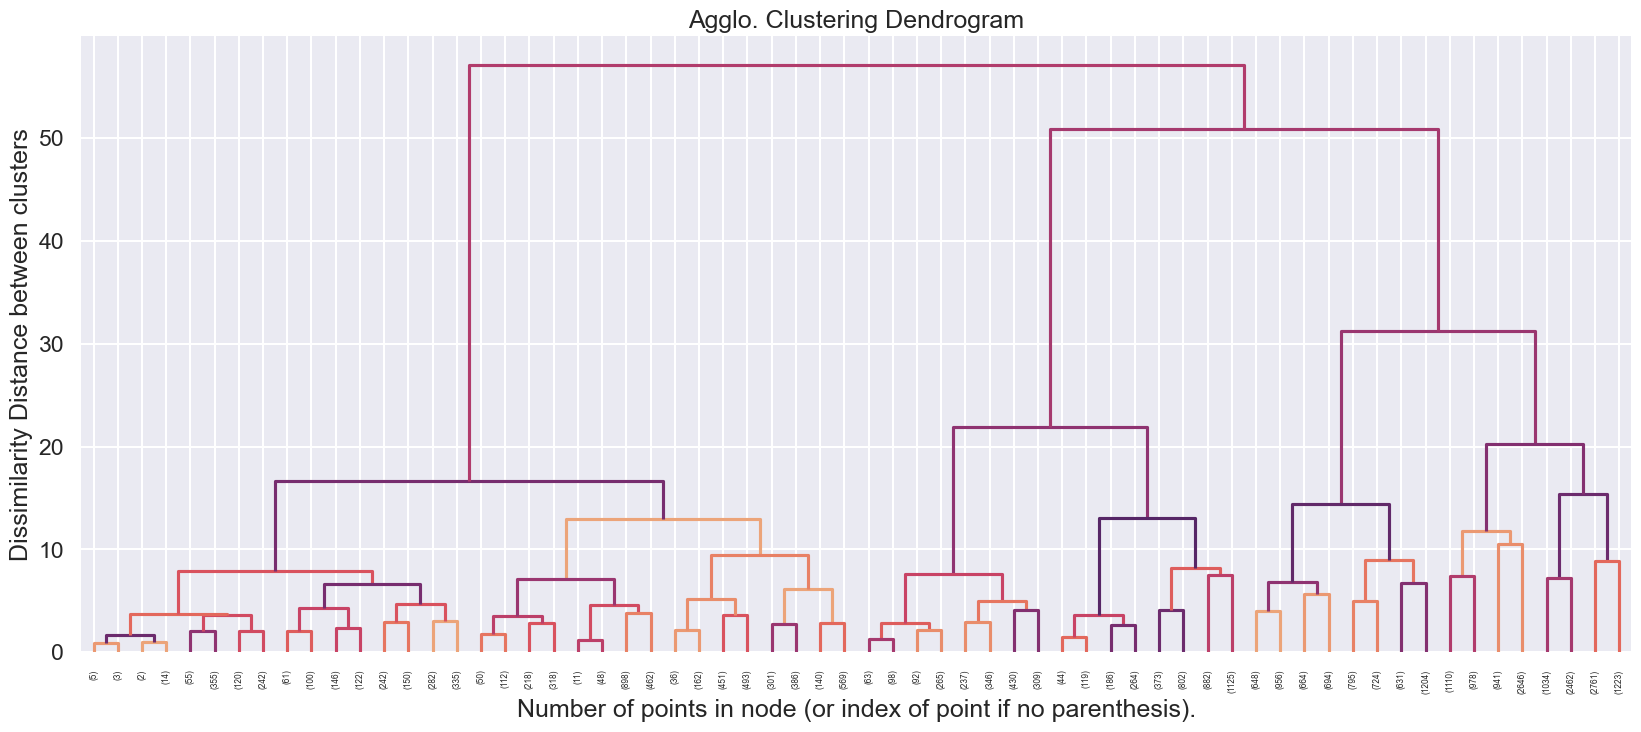

In [212]:
fig, ax = plt.subplots(figsize=(20, 8))
hex_colors = [mcolors.to_hex(color) for color in palette]
ax = plot_dendrogram(agg, link_color_func=lambda k: hex_colors[k % num_colors], truncate_mode="level", p=5)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.ylabel("Dissimilarity Distance between clusters")
plt.title("Agglo. Clustering Dendrogram")

fig.savefig(f"./{save_results_to}/agg1dendro.png", dpi=300, transparent=True)

plt.show

In [213]:
agg_df = cleaned_data.copy()
agg_df["cluster"] = agg.labels_
agg_df

Year quarter citymarketid_1 citymarketid_2  \
0      2009       2          32467          34576   
1      2009       2          32211          32467   
2      2011       4          33044          33195   
3      2009       2          30977          34524   
4      2013       2          31650          33570   
...     ...     ...            ...            ...   
31990  2023       4          35412          30852   
31991  2023       4          35412          31703   
31992  2023       4          35412          32467   
31993  2023       4          35412          33195   
31994  2023       4          35412          34761   

                               city1                                  city2  \
0      Miami, FL (Metropolitan Area)                          Rochester, NY   
1                      Las Vegas, NV          Miami, FL (Metropolitan Area)   
2                     Louisville, KY          Tampa, FL (Metropolitan Area)   
3                        Chicago, IL                           Richmond, VA   
4           Minneapolis/St. Paul, MN                          San Diego, CA   
...                              ...                                    ...   
31990                  Knoxville, TN     Washington, DC (Metropolitan Area)   
31991                  Knoxville, TN  New York City, NY (Metropolitan Area)   
31992                  Knoxville, TN          Miami, FL (Metropolitan Area)   
31993                  Knoxville, TN          Tampa, FL (Metropolitan Area)   
31994                  Knoxville, TN                            Sanford, FL   

       nsmiles  passengers    fare carrier_lg  ...  fare_lg  carrier_low  \
0         1204         203  151.46         FL  ...   131.05           FL   
1         2175        1224  200.95         AA  ...   227.52           NK   
2          727         294  174.63         WN  ...   173.66           DL   
3          642         347  169.72         UA  ...   170.57           AA   
4         1532         700  244.01         DL  ...   279.09           SY   
...        ...         ...     ...        ...  ...      ...          ...   
31990      464         339  227.32         AA  ...   218.04           AA   
31991      684         420  248.08         DL  ...   309.25           G4   
31992      724         347  180.17         G4  ...   116.00           G4   
31993      550         295  143.43         G4  ...    92.75           G4   
31994      511         309   93.24         G4  ...    93.24           G4   

        lf_ms  fare_low  table_1_flag  city1_lat  city1_long  city2_lat  \
0      0.2900    131.05             1  44.977479  -93.264346  43.155708   
1      0.1300    134.62             1  36.169202 -115.140597  44.977479   
2      0.2100    166.94             1  38.256078  -85.751569  37.860600   
3      0.2500    159.66             1  41.775002  -87.696388  37.540759   
4      0.2200    189.26             1  44.977479  -93.264346  32.715760   
...       ...       ...           ...        ...         ...        ...   
31990  0.7207    218.04            -1  35.962631  -83.916677  38.892062   
31991  0.2761    124.31            -1  35.962631  -83.916677  40.123164   
31992  0.6374    116.00            -1  35.962631  -83.916677  44.977479   
31993  0.8036     92.75            -1  35.962631  -83.916677  37.860600   
31994  1.0000     93.24            -1  35.962631  -83.916677  37.780080   

       city2_long  cluster  
0      -77.612547        2  
1      -93.264346        1  
2      -78.804199        3  
3      -77.433932        3  
4     -117.163817        2  
...           ...      ...  
31990  -77.019912        0  
31991  -75.333718        3  
31992  -93.264346        0  
31993  -78.804199        0  
31994 -122.420168        0  

[31995 rows x 21 columns]

In [214]:
city_gdf = gpd.GeoDataFrame(agg_df, geometry=gpd.points_from_xy(agg_df.city1_long, agg_df.city1_lat), crs="EPSG:4326")

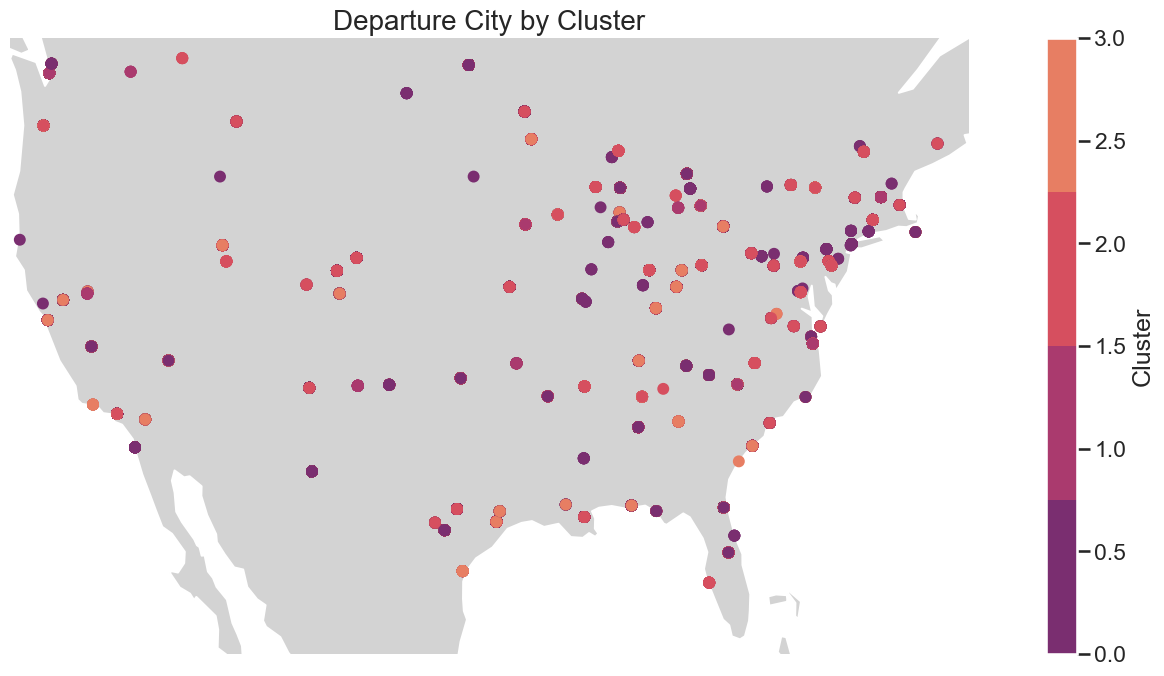

In [215]:
# Load data
world = gpd.read_file(get_path("naturalearth.land"))
# Assuming city_gdf is your GeoDataFrame with city data and cluster information

# Create a custom colormap using the Seaborn palette
n_clusters = city_gdf['cluster'].nunique()
colors = sns.color_palette(theme, n_colors=n_clusters)
cmap = LinearSegmentedColormap.from_list("custom", colors, N=n_clusters)

# Create the plot
fig, ax = plt.subplots(figsize=(20, 8))

# Plot the world map
world.plot(ax=ax, color='lightgrey', edgecolor='white')

# Plot cities with colors according to cluster
scatter = city_gdf.plot(ax=ax, column='cluster', cmap=cmap, 
                        markersize=50, marker='o', legend=True,
                        legend_kwds={'label': 'Cluster', 'orientation': 'vertical'})

# Define the bounding box for North America
xlim = (-124.7, -66.9)  # Longitude limits
ylim = (24.5, 49)  # Latitude limits

# Set the limits for North America
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_axis_off()  # Hides the axis

plt.title("Departure City by Cluster", fontsize=20)

# Adjust the legend position
leg = ax.get_legend()
fig.savefig(f"./{save_results_to}/agg1city1cluster.png", dpi=300, transparent=True)
plt.show()

In [216]:
city_gdf = gpd.GeoDataFrame(agg_df, geometry=gpd.points_from_xy(agg_df.city2_long, agg_df.city2_lat), crs="EPSG:4326")

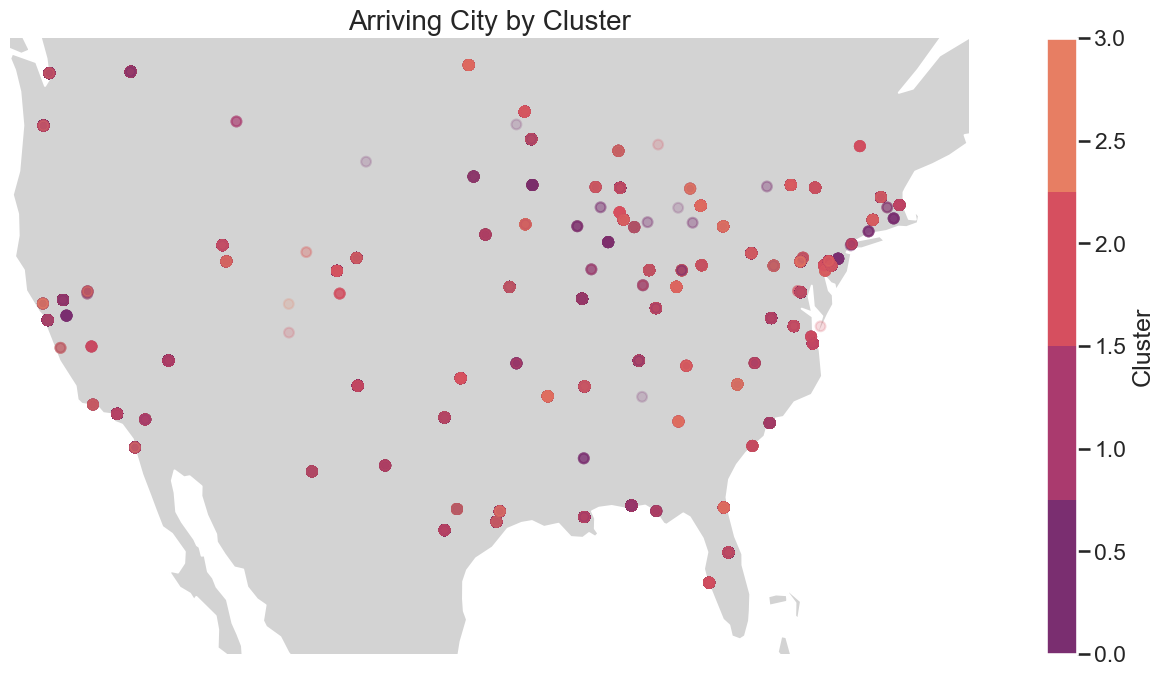

In [217]:
# Load data
world = gpd.read_file(get_path("naturalearth.land"))
# Assuming city_gdf is your GeoDataFrame with city data and cluster information

# Create a custom colormap using the Seaborn palette
n_clusters = city_gdf['cluster'].nunique()
colors = sns.color_palette(theme, n_colors=n_clusters)
cmap = LinearSegmentedColormap.from_list("custom", colors, N=n_clusters)

# Create the plot
fig, ax = plt.subplots(figsize=(20, 8))

# Plot the world map
world.plot(ax=ax, color='lightgrey', edgecolor='white')

# Plot cities with colors according to cluster
scatter = city_gdf.plot(ax=ax, column='cluster', cmap=cmap, 
                        markersize=50, marker='o', legend=True,
                        legend_kwds={'label': 'Cluster', 'orientation': 'vertical'},
                        alpha=0.2)

# Define the bounding box for North America
xlim = (-124.7, -66.9)  # Longitude limits
ylim = (24.5, 49)  # Latitude limits

# Set the limits for North America
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_axis_off()  # Hides the axis

plt.title("Arriving City by Cluster", fontsize=20)

# Adjust the legend position
leg = ax.get_legend()
fig.savefig(f"./{save_results_to}/agg1city2cluster.png", dpi=300, transparent=True)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

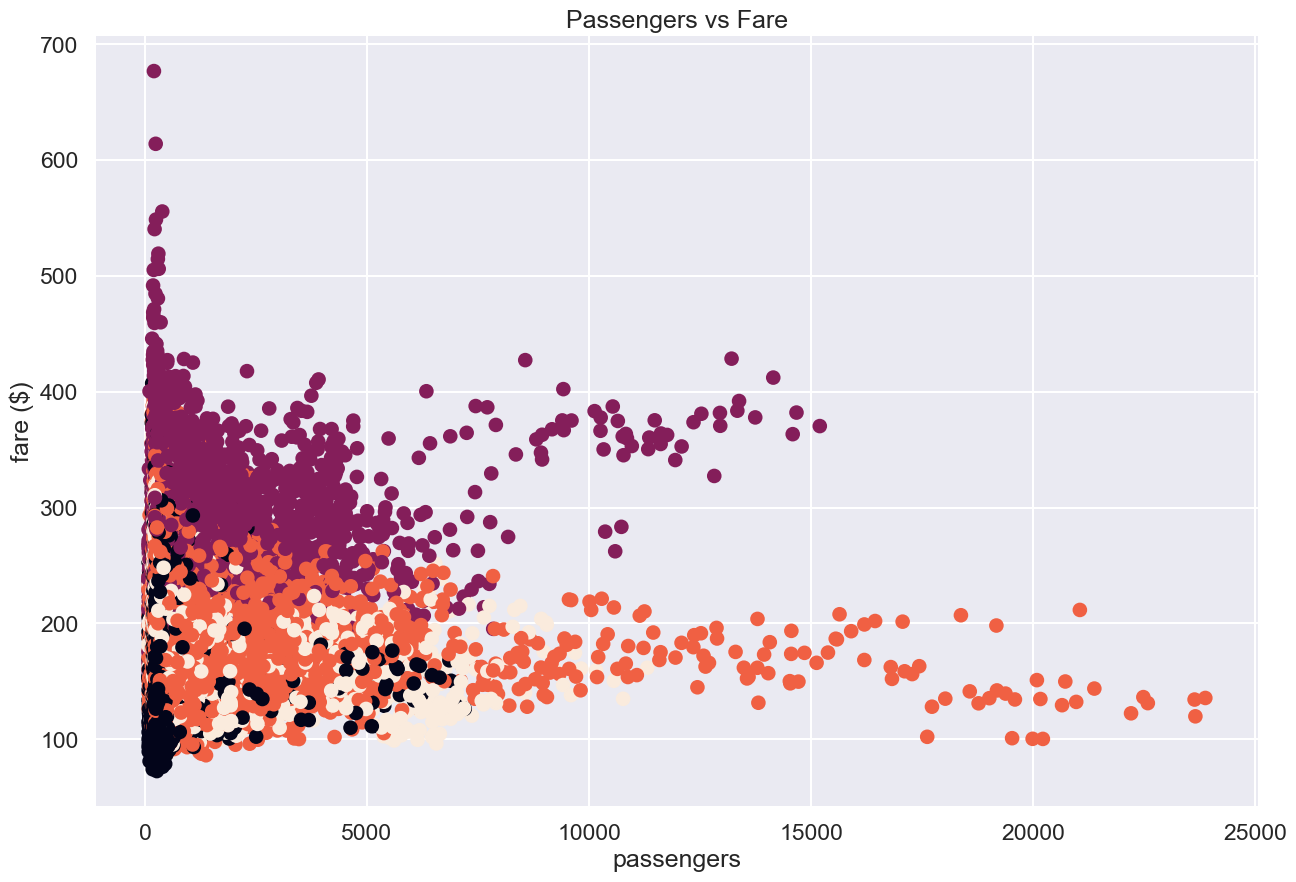

In [218]:
fig, ax = plt.subplots(figsize=(15, 10))

ax = ax.scatter(x=agg_df["passengers"], y=agg_df["fare"], c=agg_df["cluster"])
plt.title("Passengers vs Fare")
plt.xlabel("passengers")
plt.ylabel("fare ($)")
fig.savefig(f"./{save_results_to}/agg1passfare.png", dpi=300, transparent=True)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

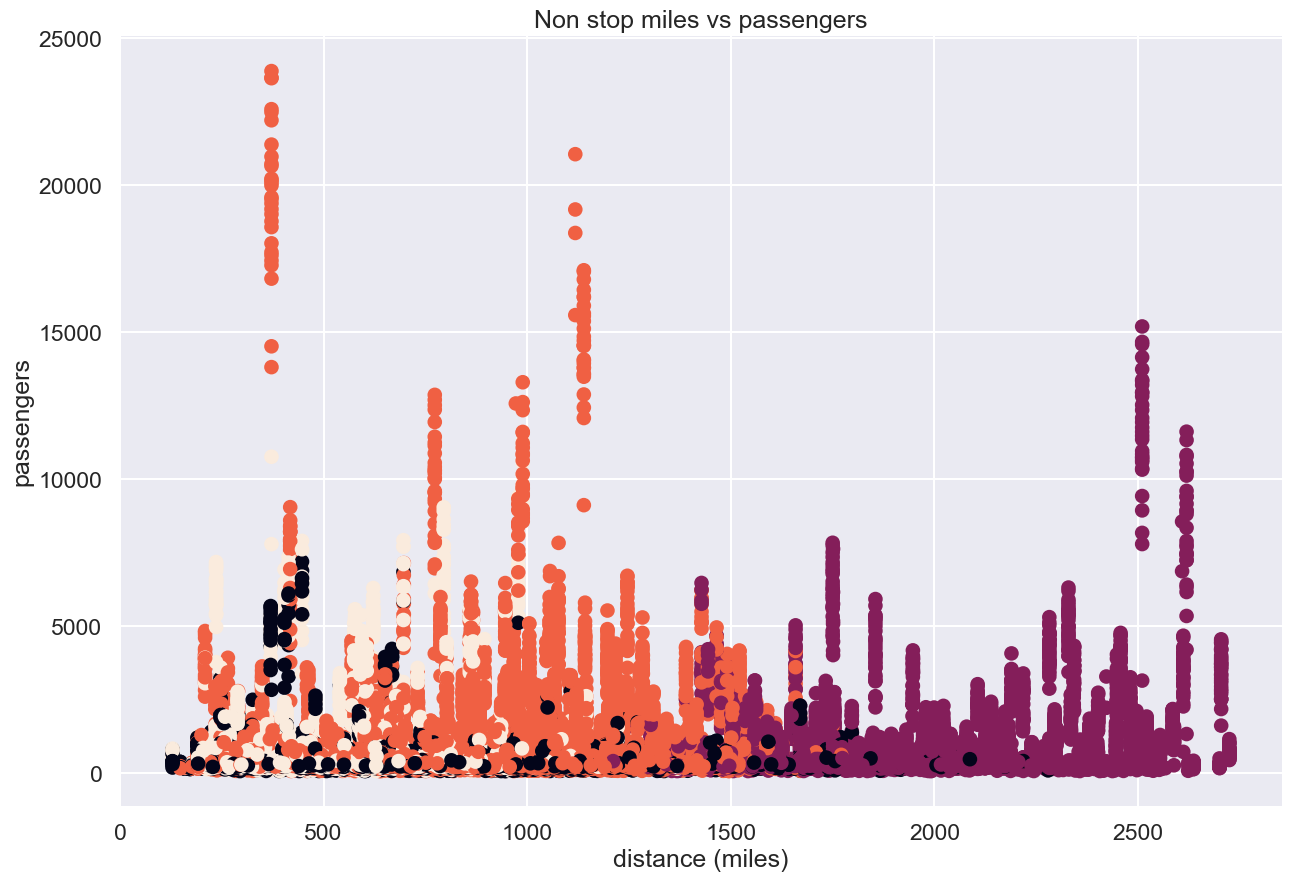

In [219]:
fig, ax = plt.subplots(figsize=(15, 10))

ax = ax.scatter(x=agg_df["nsmiles"], y=agg_df["passengers"], c=agg_df["cluster"])
plt.title("Non stop miles vs passengers")
plt.xlabel("distance (miles)")
plt.ylabel("passengers")
fig.savefig(f"./{save_results_to}/agg1milespass.png", dpi=300, transparent=True)

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

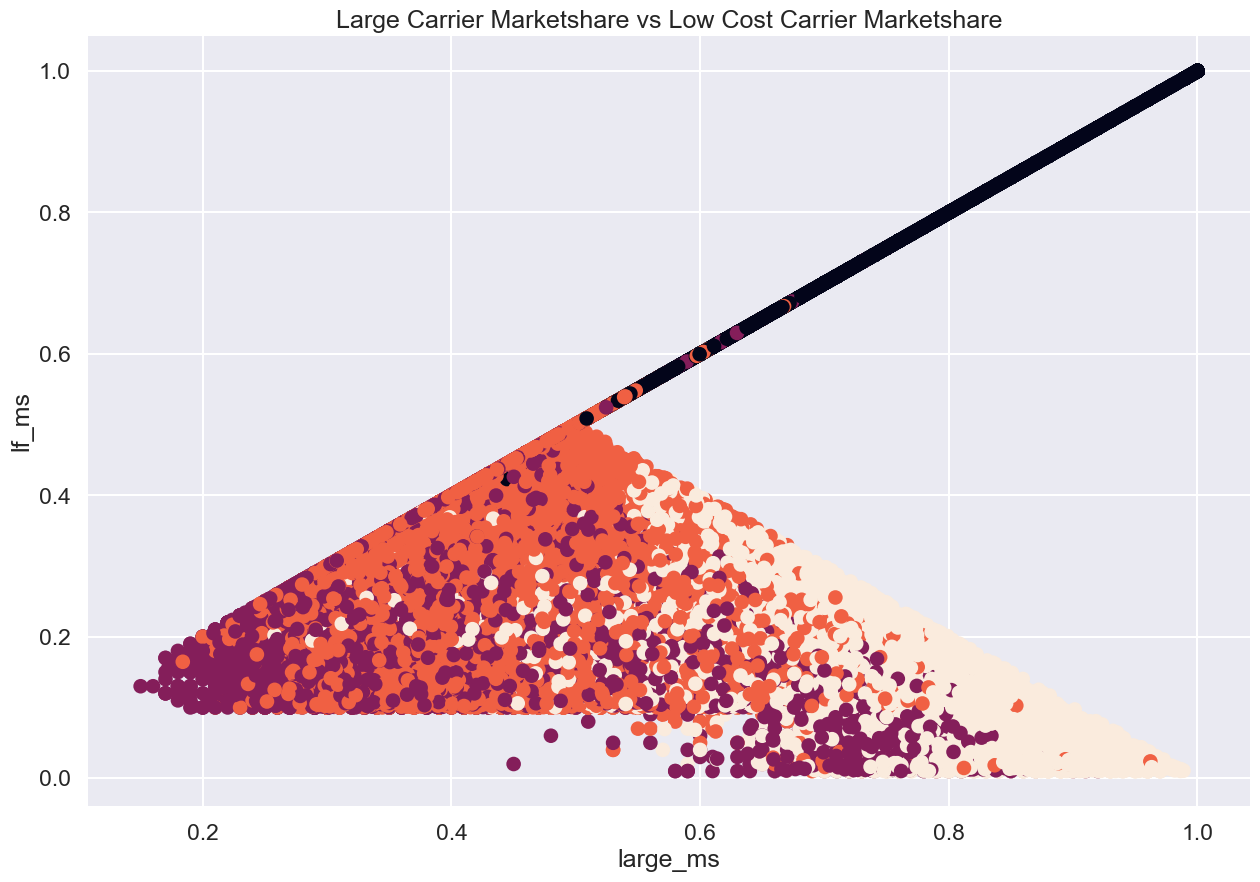

In [220]:
fig, ax = plt.subplots(figsize=(15, 10))

ax = ax.scatter(x=agg_df["large_ms"], y=agg_df["lf_ms"], c=agg_df["cluster"])
plt.title("Large Carrier Marketshare vs Low Cost Carrier Marketshare")
plt.xlabel("large_ms")
plt.ylabel("lf_ms")
fig.savefig(f"./{save_results_to}/agg1ms.png", dpi=300, transparent=True)

plt.show

Metrics

Silhouette Score:
This measures how similar an object is to its own cluster compared to other clusters.

For Silhouette Score: Higher values (closer to 1) are better.

Davies-Bouldin Index:
This index signifies the average 'similarity' between clusters, where similarity is a measure that compares the distance between clusters with the size of the clusters themselves.

For Davies-Bouldin: Lower values are better.


In [221]:
silhouette_avg = silhouette_score(X_normalized, agg.labels_)
print(f"The average silhouette score is: {silhouette_avg}")

The average silhouette score is: 0.2507565409851805


In [222]:
db_score = davies_bouldin_score(X_normalized, agg.labels_)
print(f"The Davies-Bouldin score is: {db_score}")

The Davies-Bouldin score is: 1.2707774363381936


### KMeans 1

In [223]:
kmeans = KMeans(n_clusters=5)

In [224]:
kmeans.fit(X_normalized)

KMeans(n_clusters=5)

In [225]:
km_df = cleaned_data.copy()
km_df["cluster"] = kmeans.labels_
km_df

Year quarter citymarketid_1 citymarketid_2  \
0      2009       2          32467          34576   
1      2009       2          32211          32467   
2      2011       4          33044          33195   
3      2009       2          30977          34524   
4      2013       2          31650          33570   
...     ...     ...            ...            ...   
31990  2023       4          35412          30852   
31991  2023       4          35412          31703   
31992  2023       4          35412          32467   
31993  2023       4          35412          33195   
31994  2023       4          35412          34761   

                               city1                                  city2  \
0      Miami, FL (Metropolitan Area)                          Rochester, NY   
1                      Las Vegas, NV          Miami, FL (Metropolitan Area)   
2                     Louisville, KY          Tampa, FL (Metropolitan Area)   
3                        Chicago, IL                           Richmond, VA   
4           Minneapolis/St. Paul, MN                          San Diego, CA   
...                              ...                                    ...   
31990                  Knoxville, TN     Washington, DC (Metropolitan Area)   
31991                  Knoxville, TN  New York City, NY (Metropolitan Area)   
31992                  Knoxville, TN          Miami, FL (Metropolitan Area)   
31993                  Knoxville, TN          Tampa, FL (Metropolitan Area)   
31994                  Knoxville, TN                            Sanford, FL   

       nsmiles  passengers    fare carrier_lg  ...  fare_lg  carrier_low  \
0         1204         203  151.46         FL  ...   131.05           FL   
1         2175        1224  200.95         AA  ...   227.52           NK   
2          727         294  174.63         WN  ...   173.66           DL   
3          642         347  169.72         UA  ...   170.57           AA   
4         1532         700  244.01         DL  ...   279.09           SY   
...        ...         ...     ...        ...  ...      ...          ...   
31990      464         339  227.32         AA  ...   218.04           AA   
31991      684         420  248.08         DL  ...   309.25           G4   
31992      724         347  180.17         G4  ...   116.00           G4   
31993      550         295  143.43         G4  ...    92.75           G4   
31994      511         309   93.24         G4  ...    93.24           G4   

        lf_ms  fare_low  table_1_flag  city1_lat  city1_long  city2_lat  \
0      0.2900    131.05             1  44.977479  -93.264346  43.155708   
1      0.1300    134.62             1  36.169202 -115.140597  44.977479   
2      0.2100    166.94             1  38.256078  -85.751569  37.860600   
3      0.2500    159.66             1  41.775002  -87.696388  37.540759   
4      0.2200    189.26             1  44.977479  -93.264346  32.715760   
...       ...       ...           ...        ...         ...        ...   
31990  0.7207    218.04            -1  35.962631  -83.916677  38.892062   
31991  0.2761    124.31            -1  35.962631  -83.916677  40.123164   
31992  0.6374    116.00            -1  35.962631  -83.916677  44.977479   
31993  0.8036     92.75            -1  35.962631  -83.916677  37.860600   
31994  1.0000     93.24            -1  35.962631  -83.916677  37.780080   

       city2_long  cluster  
0      -77.612547        0  
1      -93.264346        3  
2      -78.804199        2  
3      -77.433932        2  
4     -117.163817        3  
...           ...      ...  
31990  -77.019912        4  
31991  -75.333718        0  
31992  -93.264346        1  
31993  -78.804199        4  
31994 -122.420168        4  

[31995 rows x 21 columns]

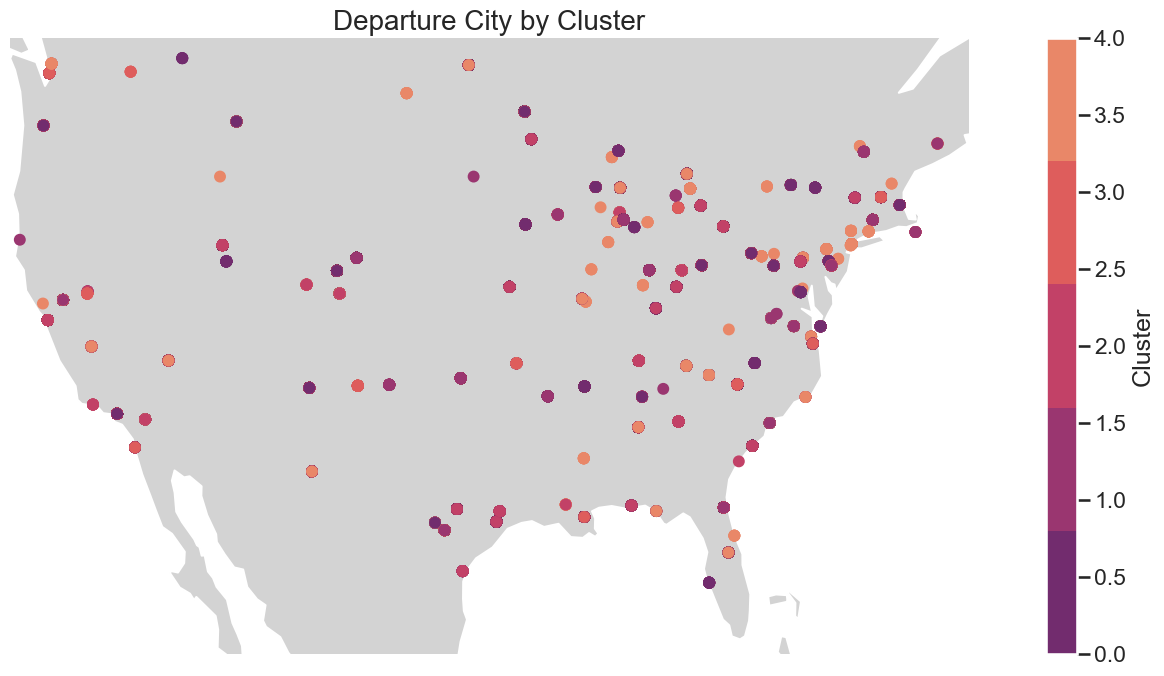

In [226]:
city_gdf = gpd.GeoDataFrame(km_df, geometry=gpd.points_from_xy(km_df.city1_long, km_df.city1_lat), crs="EPSG:4326")
# Load data
world = gpd.read_file(get_path("naturalearth.land"))
# Assuming city_gdf is your GeoDataFrame with city data and cluster information

# Create a custom colormap using the Seaborn palette
n_clusters = city_gdf['cluster'].nunique()
colors = sns.color_palette(theme, n_colors=n_clusters)
cmap = LinearSegmentedColormap.from_list("custom", colors, N=n_clusters)

# Create the plot
fig, ax = plt.subplots(figsize=(20, 8))

# Plot the world map
world.plot(ax=ax, color='lightgrey', edgecolor='white')

# Plot cities with colors according to cluster
scatter = city_gdf.plot(ax=ax, column='cluster', cmap=cmap, 
                        markersize=50, marker='o', legend=True,
                        legend_kwds={'label': 'Cluster', 'orientation': 'vertical'})

# Define the bounding box for North America
xlim = (-124.7, -66.9)  # Longitude limits
ylim = (24.5, 49)  # Latitude limits

# Set the limits for North America
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_axis_off()  # Hides the axis

plt.title("Departure City by Cluster", fontsize=20)

# Adjust the legend position
leg = ax.get_legend()
fig.savefig(f"./{save_results_to}/km1city1cluster.png", dpi=300, transparent=True)
plt.show()

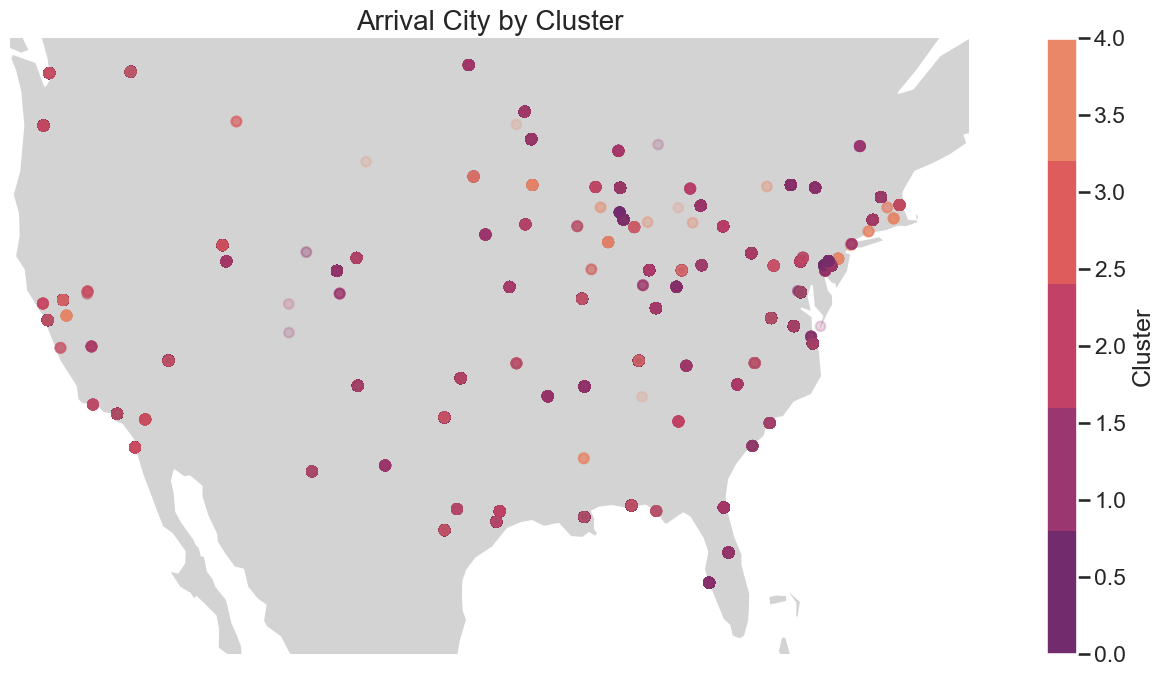

In [227]:
city_gdf = gpd.GeoDataFrame(km_df, geometry=gpd.points_from_xy(km_df.city2_long, km_df.city2_lat), crs="EPSG:4326")
# Load data
world = gpd.read_file(get_path("naturalearth.land"))
# Assuming city_gdf is your GeoDataFrame with city data and cluster information

# Create a custom colormap using the Seaborn palette
n_clusters = city_gdf['cluster'].nunique()
colors = sns.color_palette(theme, n_colors=n_clusters)
cmap = LinearSegmentedColormap.from_list("custom", colors, N=n_clusters)

# Create the plot
fig, ax = plt.subplots(figsize=(20, 8))

# Plot the world map
world.plot(ax=ax, color='lightgrey', edgecolor='white')

# Plot cities with colors according to cluster
scatter = city_gdf.plot(ax=ax, column='cluster', cmap=cmap, 
                        markersize=50, marker='o', legend=True,
                        legend_kwds={'label': 'Cluster', 'orientation': 'vertical'},
                        alpha=0.2)

# Define the bounding box for North America
xlim = (-124.7, -66.9)  # Longitude limits
ylim = (24.5, 49)  # Latitude limits

# Set the limits for North America
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_axis_off()  # Hides the axis

plt.title("Arrival City by Cluster", fontsize=20)

# Adjust the legend position
leg = ax.get_legend()
fig.savefig(f"./{save_results_to}/km1city2cluster.png", dpi=300, transparent=True)
plt.show()

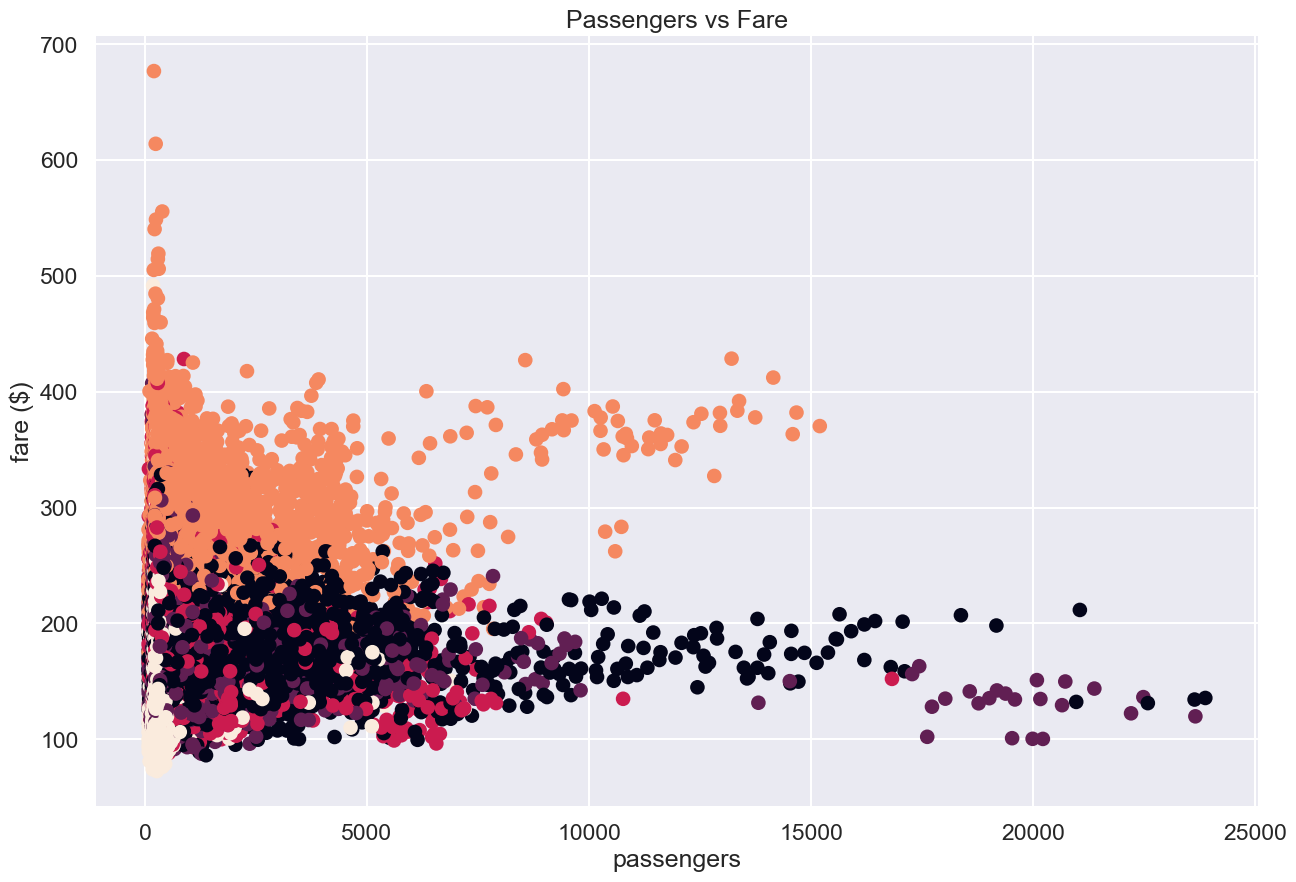

In [228]:
fig, ax = plt.subplots(figsize=(15, 10))

ax = ax.scatter(x=km_df["passengers"], y=km_df["fare"], c=km_df["cluster"])
plt.title("Passengers vs Fare")
plt.xlabel("passengers")
plt.ylabel("fare ($)")
fig.savefig(f"./{save_results_to}/km1passfare.png", dpi=300, transparent=True)
plt.show()

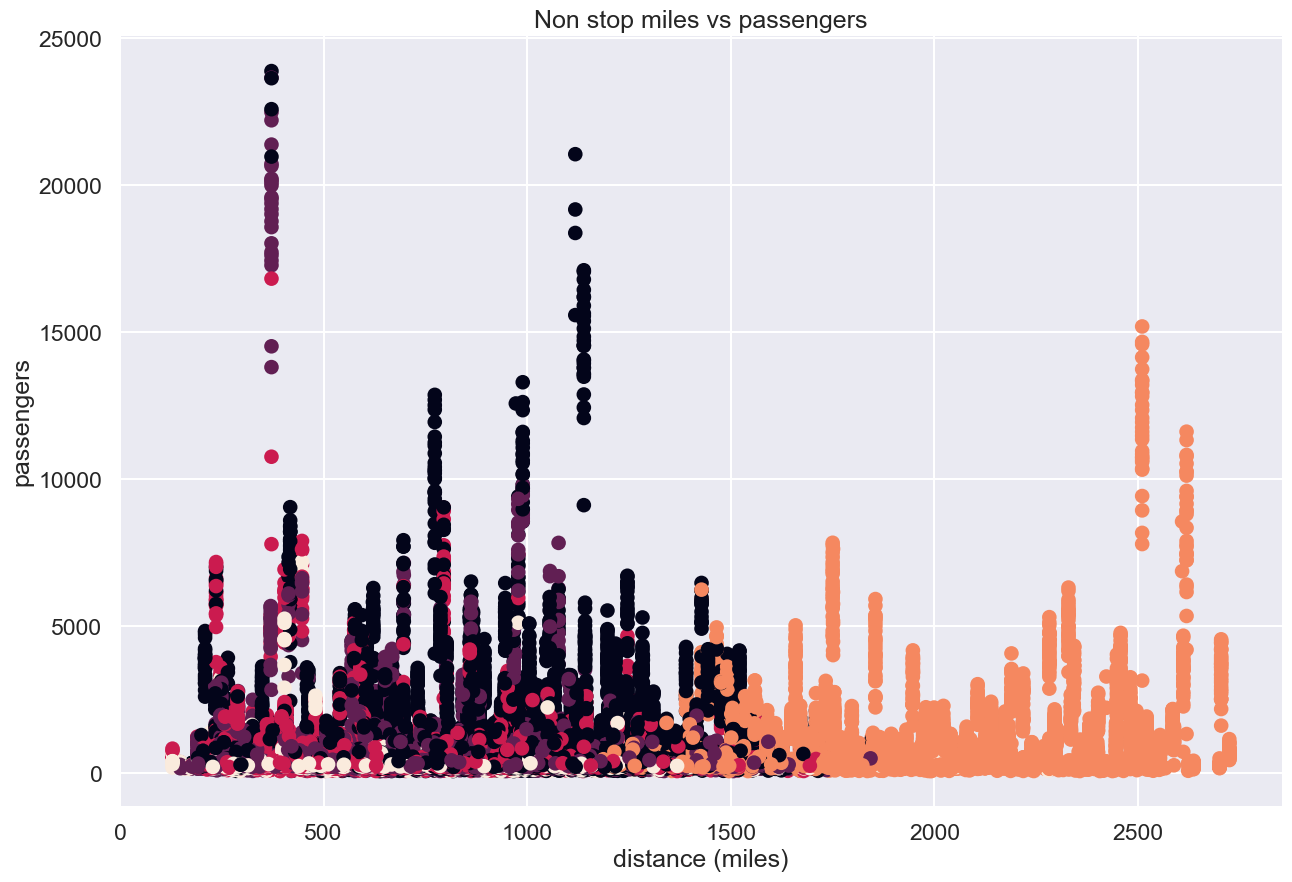

In [229]:
fig, ax = plt.subplots(figsize=(15, 10))

ax = ax.scatter(x=km_df["nsmiles"], y=km_df["passengers"], c=km_df["cluster"])
plt.title("Non stop miles vs passengers")
plt.xlabel("distance (miles)")
plt.ylabel("passengers")
fig.savefig(f"./{save_results_to}/km1milespass.png", dpi=300, transparent=True)

plt.show()

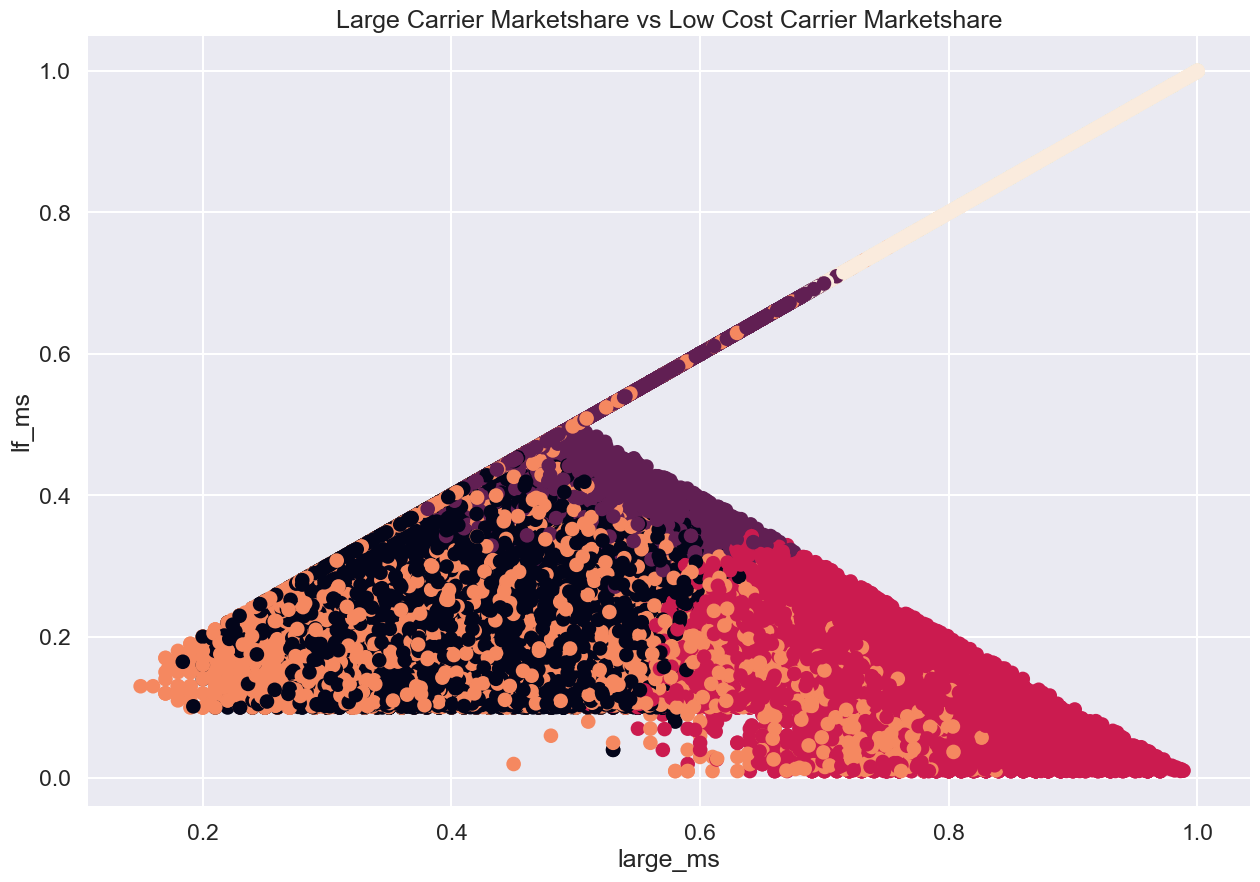

In [230]:
fig, ax = plt.subplots(figsize=(15, 10))

ax = ax.scatter(x=km_df["large_ms"], y=km_df["lf_ms"], c=km_df["cluster"])
plt.title("Large Carrier Marketshare vs Low Cost Carrier Marketshare")
plt.xlabel("large_ms")
plt.ylabel("lf_ms")
fig.savefig(f"./{save_results_to}/km1ms.png", dpi=300, transparent=True)

plt.show()

In [231]:
silhouette_avg = silhouette_score(X_normalized, kmeans.labels_)
print(f"The average silhouette score is: {silhouette_avg}")

The average silhouette score is: 0.27390316105140183


In [232]:
db_score = davies_bouldin_score(X_normalized, kmeans.labels_)
print(f"The Davies-Bouldin score is: {db_score}")

The Davies-Bouldin score is: 1.17772979913715


### KMeans 2

In [233]:
kmeans = KMeans(n_clusters=2)

In [234]:
kmeans.fit(X_normalized)

KMeans(n_clusters=2)

In [235]:
km_df = cleaned_data.copy()
km_df["cluster"] = kmeans.labels_
km_df

Year quarter citymarketid_1 citymarketid_2  \
0      2009       2          32467          34576   
1      2009       2          32211          32467   
2      2011       4          33044          33195   
3      2009       2          30977          34524   
4      2013       2          31650          33570   
...     ...     ...            ...            ...   
31990  2023       4          35412          30852   
31991  2023       4          35412          31703   
31992  2023       4          35412          32467   
31993  2023       4          35412          33195   
31994  2023       4          35412          34761   

                               city1                                  city2  \
0      Miami, FL (Metropolitan Area)                          Rochester, NY   
1                      Las Vegas, NV          Miami, FL (Metropolitan Area)   
2                     Louisville, KY          Tampa, FL (Metropolitan Area)   
3                        Chicago, IL                           Richmond, VA   
4           Minneapolis/St. Paul, MN                          San Diego, CA   
...                              ...                                    ...   
31990                  Knoxville, TN     Washington, DC (Metropolitan Area)   
31991                  Knoxville, TN  New York City, NY (Metropolitan Area)   
31992                  Knoxville, TN          Miami, FL (Metropolitan Area)   
31993                  Knoxville, TN          Tampa, FL (Metropolitan Area)   
31994                  Knoxville, TN                            Sanford, FL   

       nsmiles  passengers    fare carrier_lg  ...  fare_lg  carrier_low  \
0         1204         203  151.46         FL  ...   131.05           FL   
1         2175        1224  200.95         AA  ...   227.52           NK   
2          727         294  174.63         WN  ...   173.66           DL   
3          642         347  169.72         UA  ...   170.57           AA   
4         1532         700  244.01         DL  ...   279.09           SY   
...        ...         ...     ...        ...  ...      ...          ...   
31990      464         339  227.32         AA  ...   218.04           AA   
31991      684         420  248.08         DL  ...   309.25           G4   
31992      724         347  180.17         G4  ...   116.00           G4   
31993      550         295  143.43         G4  ...    92.75           G4   
31994      511         309   93.24         G4  ...    93.24           G4   

        lf_ms  fare_low  table_1_flag  city1_lat  city1_long  city2_lat  \
0      0.2900    131.05             1  44.977479  -93.264346  43.155708   
1      0.1300    134.62             1  36.169202 -115.140597  44.977479   
2      0.2100    166.94             1  38.256078  -85.751569  37.860600   
3      0.2500    159.66             1  41.775002  -87.696388  37.540759   
4      0.2200    189.26             1  44.977479  -93.264346  32.715760   
...       ...       ...           ...        ...         ...        ...   
31990  0.7207    218.04            -1  35.962631  -83.916677  38.892062   
31991  0.2761    124.31            -1  35.962631  -83.916677  40.123164   
31992  0.6374    116.00            -1  35.962631  -83.916677  44.977479   
31993  0.8036     92.75            -1  35.962631  -83.916677  37.860600   
31994  1.0000     93.24            -1  35.962631  -83.916677  37.780080   

       city2_long  cluster  
0      -77.612547        1  
1      -93.264346        1  
2      -78.804199        1  
3      -77.433932        1  
4     -117.163817        1  
...           ...      ...  
31990  -77.019912        0  
31991  -75.333718        1  
31992  -93.264346        0  
31993  -78.804199        0  
31994 -122.420168        0  

[31995 rows x 21 columns]

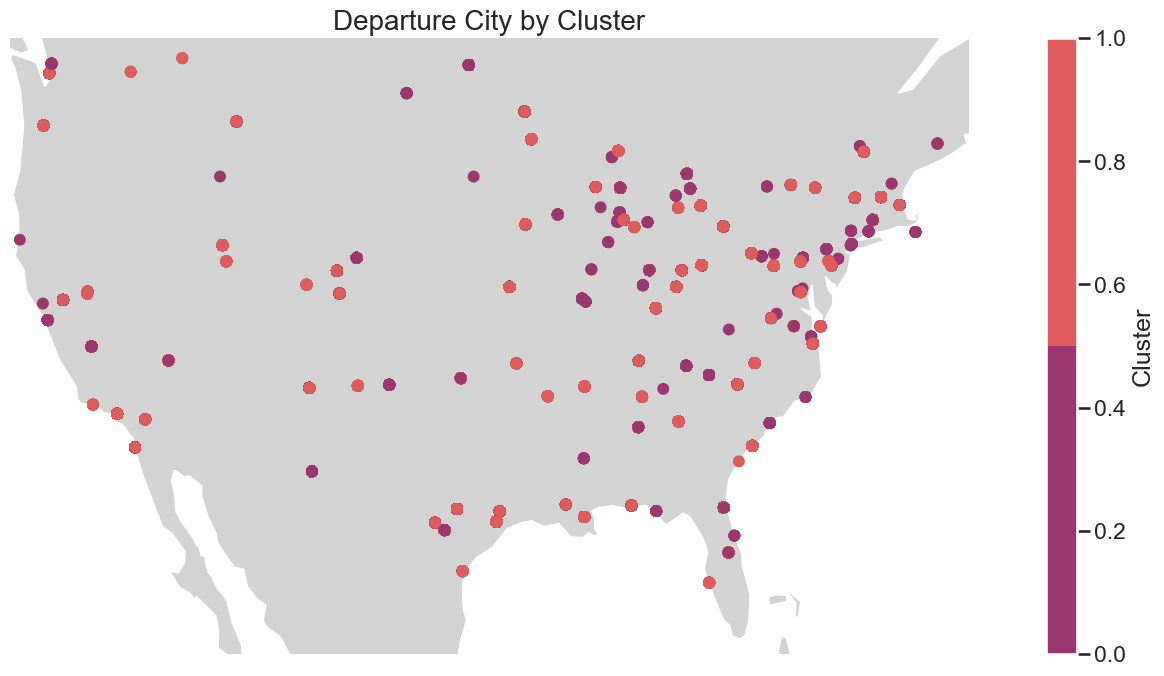

In [236]:
city_gdf = gpd.GeoDataFrame(km_df, geometry=gpd.points_from_xy(km_df.city1_long, km_df.city1_lat), crs="EPSG:4326")
# Load data
world = gpd.read_file(get_path("naturalearth.land"))
# Assuming city_gdf is your GeoDataFrame with city data and cluster information

# Create a custom colormap using the Seaborn palette
n_clusters = city_gdf['cluster'].nunique()
colors = sns.color_palette(theme, n_colors=n_clusters)
cmap = LinearSegmentedColormap.from_list("custom", colors, N=n_clusters)

# Create the plot
fig, ax = plt.subplots(figsize=(20, 8))

# Plot the world map
world.plot(ax=ax, color='lightgrey', edgecolor='white')

# Plot cities with colors according to cluster
scatter = city_gdf.plot(ax=ax, column='cluster', cmap=cmap, 
                        markersize=50, marker='o', legend=True,
                        legend_kwds={'label': 'Cluster', 'orientation': 'vertical'})

# Define the bounding box for North America
xlim = (-124.7, -66.9)  # Longitude limits
ylim = (24.5, 49)  # Latitude limits

# Set the limits for North America
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_axis_off()  # Hides the axis

plt.title("Departure City by Cluster", fontsize=20)

# Adjust the legend position
leg = ax.get_legend()
fig.savefig(f"./{save_results_to}/km2city1cluster.png", dpi=300, transparent=True)
plt.show()

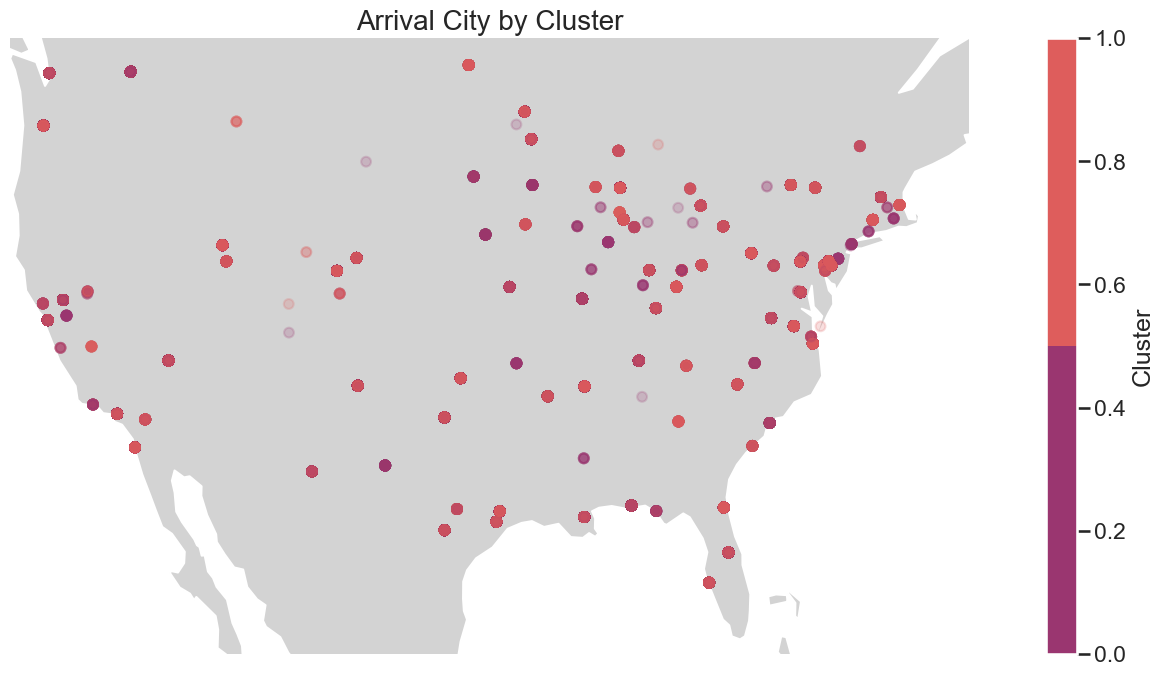

In [237]:
city_gdf = gpd.GeoDataFrame(km_df, geometry=gpd.points_from_xy(km_df.city2_long, km_df.city2_lat), crs="EPSG:4326")
# Load data
world = gpd.read_file(get_path("naturalearth.land"))
# Assuming city_gdf is your GeoDataFrame with city data and cluster information

# Create a custom colormap using the Seaborn palette
n_clusters = city_gdf['cluster'].nunique()
colors = sns.color_palette(theme, n_colors=n_clusters)
cmap = LinearSegmentedColormap.from_list("custom", colors, N=n_clusters)

# Create the plot
fig, ax = plt.subplots(figsize=(20, 8))

# Plot the world map
world.plot(ax=ax, color='lightgrey', edgecolor='white')

# Plot cities with colors according to cluster
scatter = city_gdf.plot(ax=ax, column='cluster', cmap=cmap, 
                        markersize=50, marker='o', legend=True,
                        legend_kwds={'label': 'Cluster', 'orientation': 'vertical'},
                        alpha=0.2)

# Define the bounding box for North America
xlim = (-124.7, -66.9)  # Longitude limits
ylim = (24.5, 49)  # Latitude limits

# Set the limits for North America
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_axis_off()  # Hides the axis

plt.title("Arrival City by Cluster", fontsize=20)

# Adjust the legend position
leg = ax.get_legend()
fig.savefig(f"./{save_results_to}/km2city2cluster.png", dpi=300, transparent=True)
plt.show()

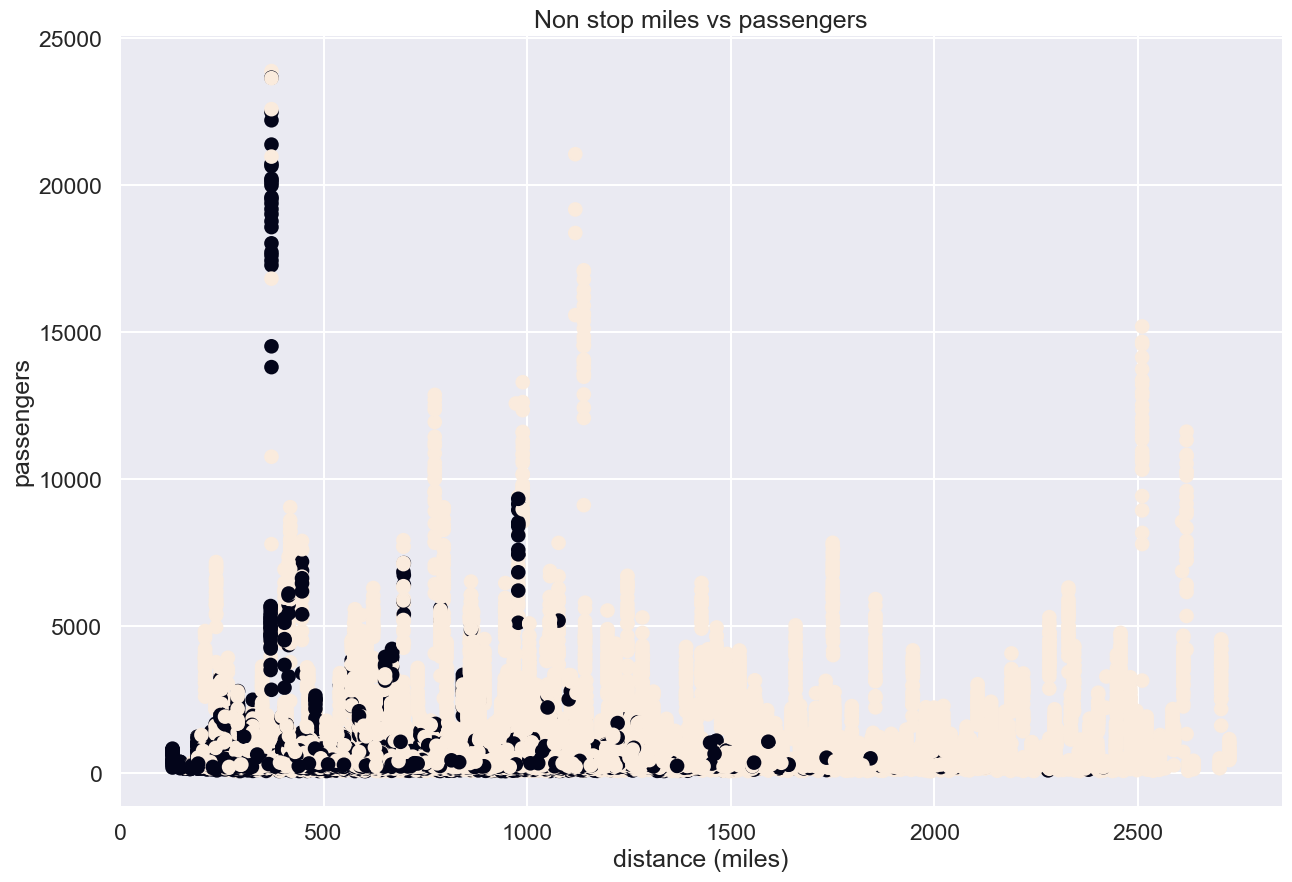

In [238]:
fig, ax = plt.subplots(figsize=(15, 10))

ax = ax.scatter(x=km_df["nsmiles"], y=km_df["passengers"], c=km_df["cluster"])
plt.title("Non stop miles vs passengers")
plt.xlabel("distance (miles)")
plt.ylabel("passengers")
fig.savefig(f"./{save_results_to}/km2milespass.png", dpi=300, transparent=True)

plt.show()

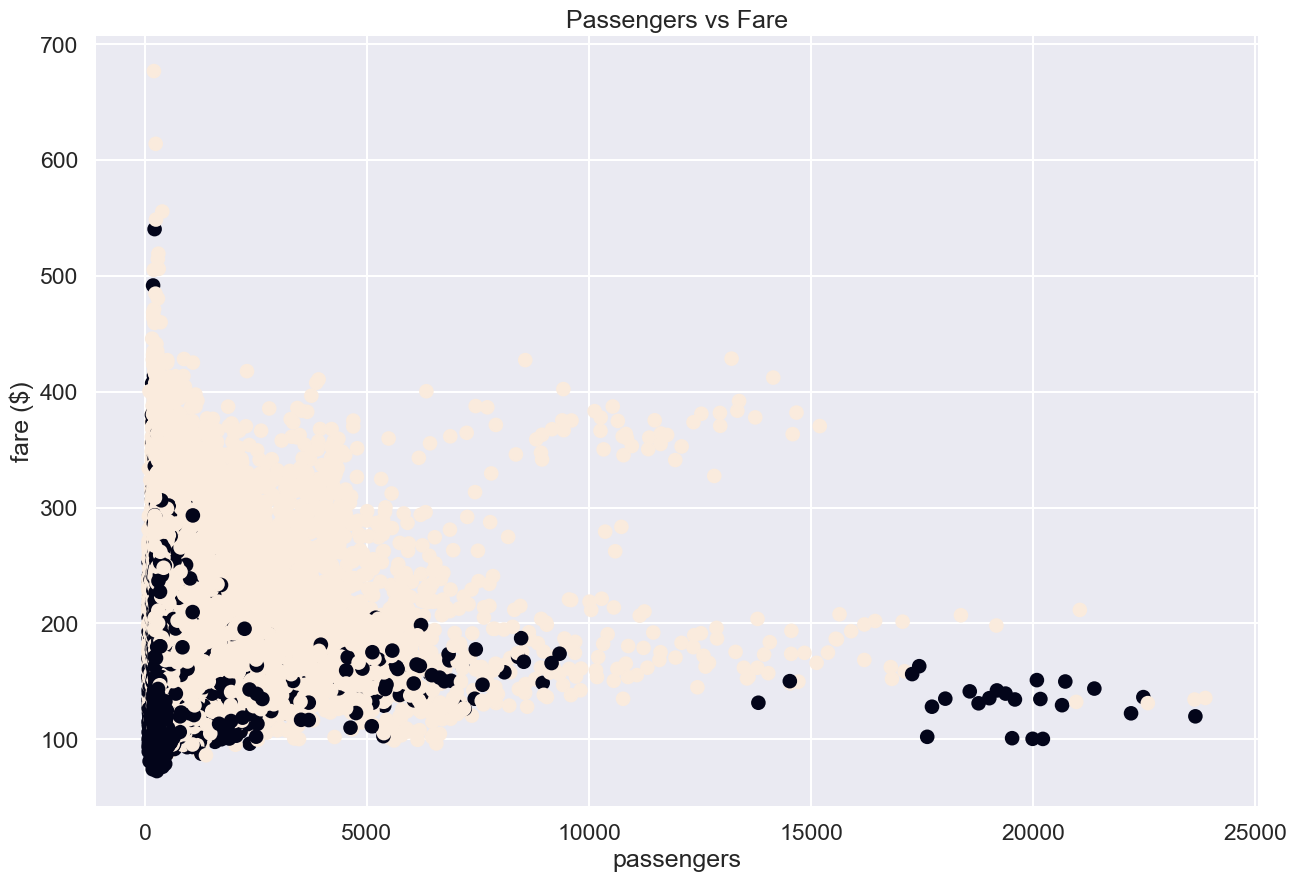

In [239]:
fig, ax = plt.subplots(figsize=(15, 10))

ax = ax.scatter(x=km_df["passengers"], y=km_df["fare"], c=km_df["cluster"])
plt.title("Passengers vs Fare")
plt.xlabel("passengers")
plt.ylabel("fare ($)")
fig.savefig(f"./{save_results_to}/km2passfare.png", dpi=300, transparent=True)

plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

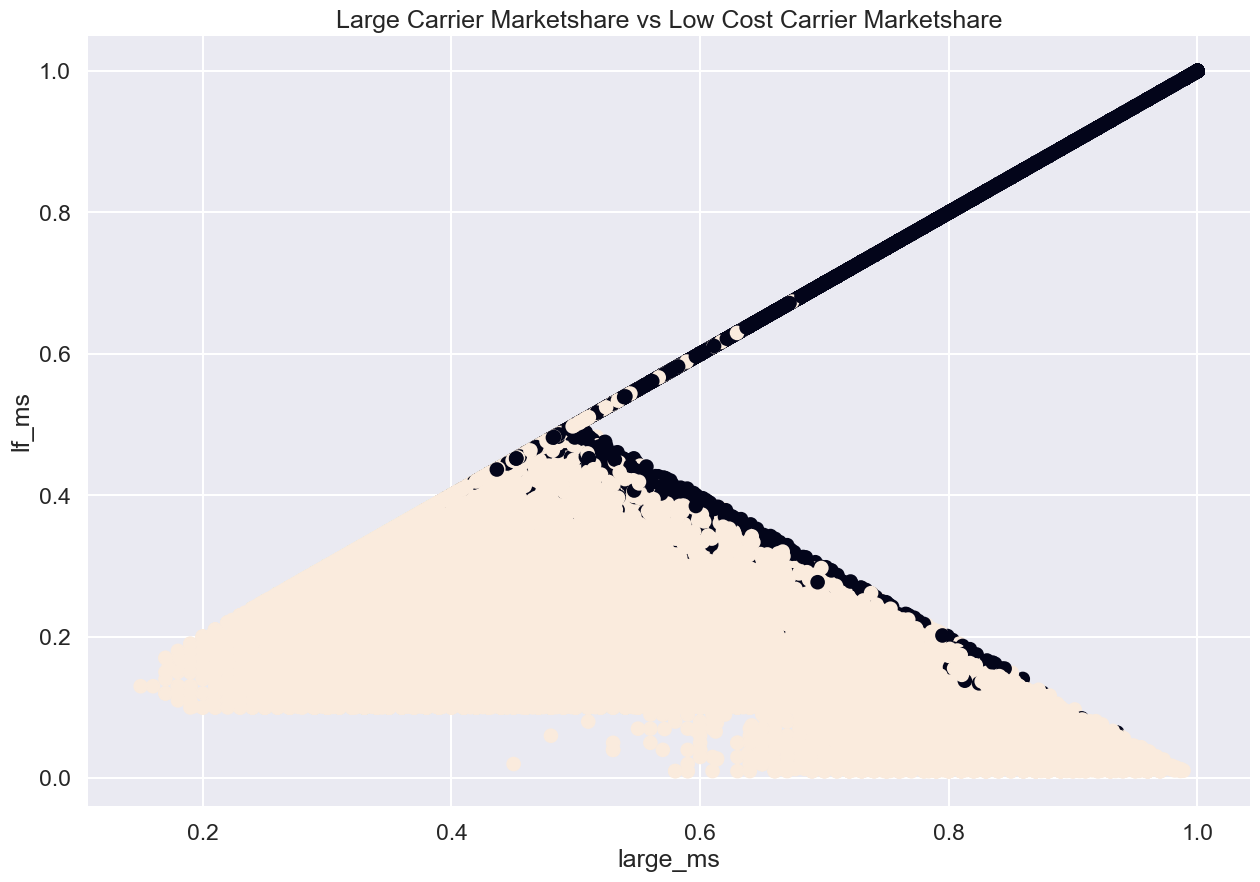

In [240]:
fig, ax = plt.subplots(figsize=(15, 10))

ax = ax.scatter(x=km_df["large_ms"], y=km_df["lf_ms"], c=km_df["cluster"])

plt.title("Large Carrier Marketshare vs Low Cost Carrier Marketshare")
plt.xlabel("large_ms")
plt.ylabel("lf_ms")
fig.savefig(f"./{save_results_to}/km2ms.png", dpi=300, transparent=True)

plt.show

In [241]:
silhouette_avg = silhouette_score(X_normalized, kmeans.labels_)
print(f"The average silhouette score is: {silhouette_avg}")

The average silhouette score is: 0.2901062302893411


In [242]:
db_score = davies_bouldin_score(X_normalized, kmeans.labels_)
print(f"The Davies-Bouldin score is: {db_score}")

The Davies-Bouldin score is: 1.2307796042861823


### KMeans3 Try without Market Share data

In [243]:
X_noms = X_normalized.drop(["lf_ms", "large_ms"], axis=1)

In [244]:
kmeans = KMeans(n_clusters=2)

In [245]:
kmeans.fit(X_noms)

KMeans(n_clusters=2)

In [246]:
km_df = cleaned_data.copy()
km_df["cluster"] = kmeans.labels_

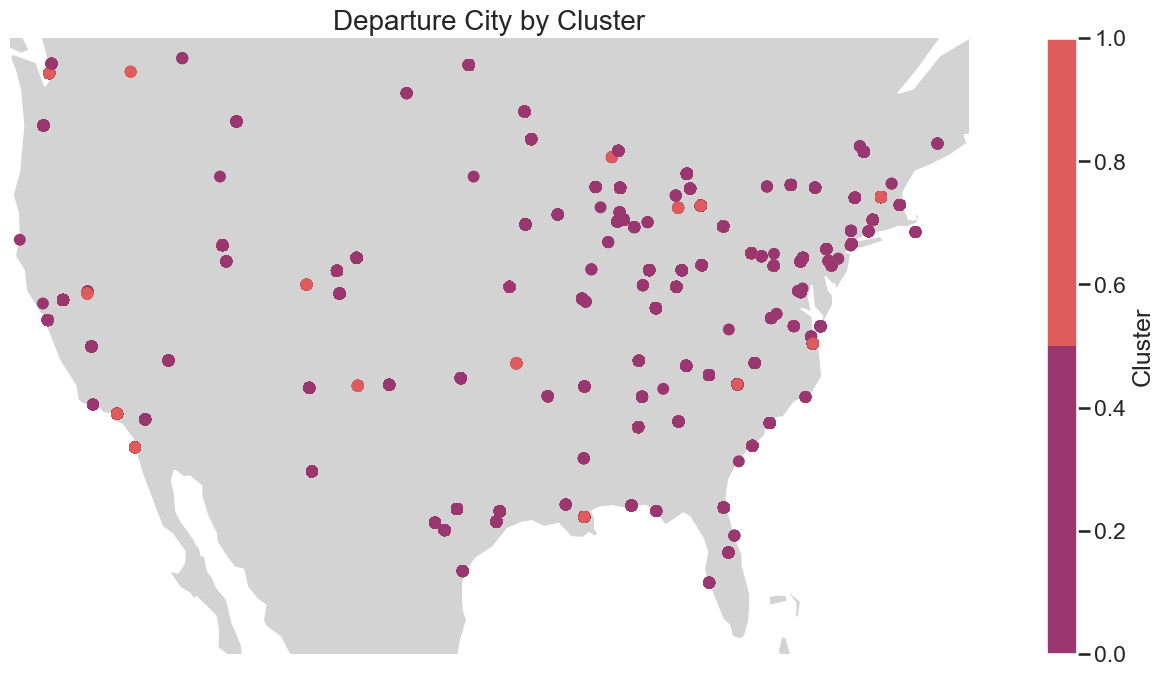

In [247]:
city_gdf = gpd.GeoDataFrame(km_df, geometry=gpd.points_from_xy(km_df.city1_long, km_df.city1_lat), crs="EPSG:4326")
# Load data
world = gpd.read_file(get_path("naturalearth.land"))
# Assuming city_gdf is your GeoDataFrame with city data and cluster information

# Create a custom colormap using the Seaborn palette
n_clusters = city_gdf['cluster'].nunique()
colors = sns.color_palette(theme, n_colors=n_clusters)
cmap = LinearSegmentedColormap.from_list("custom", colors, N=n_clusters)

# Create the plot
fig, ax = plt.subplots(figsize=(20, 8))

# Plot the world map
world.plot(ax=ax, color='lightgrey', edgecolor='white')

# Plot cities with colors according to cluster
scatter = city_gdf.plot(ax=ax, column='cluster', cmap=cmap, 
                        markersize=50, marker='o', legend=True,
                        legend_kwds={'label': 'Cluster', 'orientation': 'vertical'})

# Define the bounding box for North America
xlim = (-124.7, -66.9)  # Longitude limits
ylim = (24.5, 49)  # Latitude limits

# Set the limits for North America
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_axis_off()  # Hides the axis

plt.title("Departure City by Cluster", fontsize=20)

# Adjust the legend position
leg = ax.get_legend()
fig.savefig(f"./{save_results_to}/km3city1cluster.png", dpi=300, transparent=True)
plt.show()

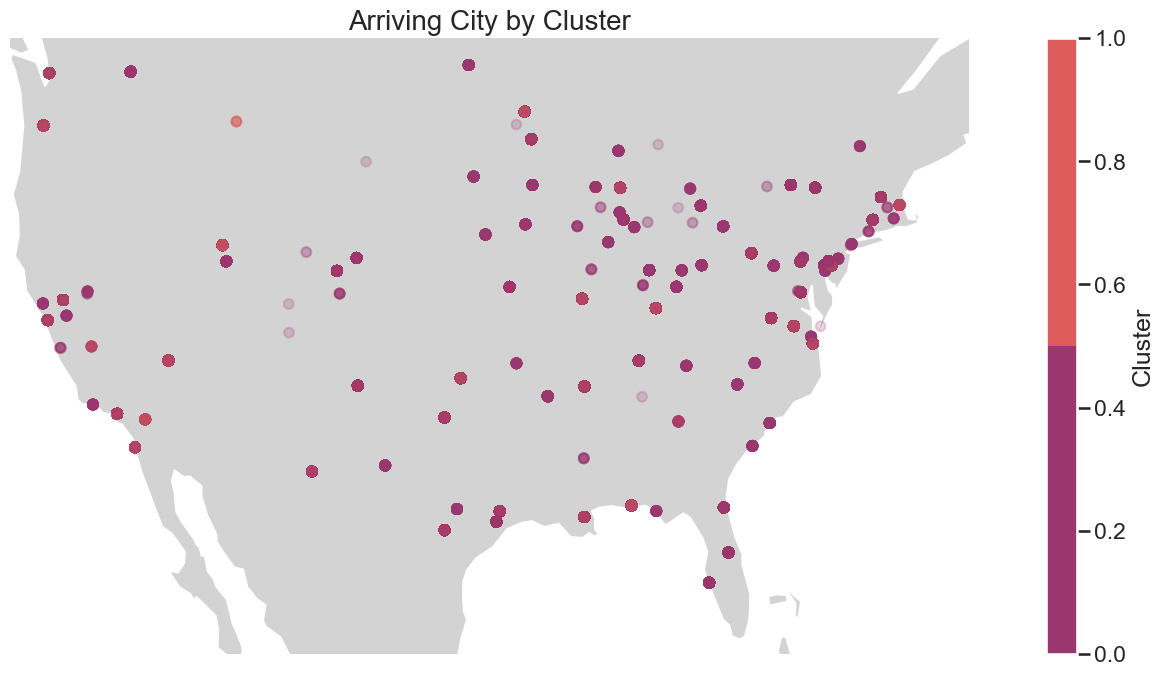

In [248]:
city_gdf = gpd.GeoDataFrame(km_df, geometry=gpd.points_from_xy(km_df.city2_long, km_df.city2_lat), crs="EPSG:4326")
# Load data
world = gpd.read_file(get_path("naturalearth.land"))
# Assuming city_gdf is your GeoDataFrame with city data and cluster information

# Create a custom colormap using the Seaborn palette
n_clusters = city_gdf['cluster'].nunique()
colors = sns.color_palette(theme, n_colors=n_clusters)
cmap = LinearSegmentedColormap.from_list("custom", colors, N=n_clusters)

# Create the plot
fig, ax = plt.subplots(figsize=(20, 8))

# Plot the world map
world.plot(ax=ax, color='lightgrey', edgecolor='white')

# Plot cities with colors according to cluster
scatter = city_gdf.plot(ax=ax, column='cluster', cmap=cmap, 
                        markersize=50, marker='o', legend=True,
                        legend_kwds={'label': 'Cluster', 'orientation': 'vertical'},
                        alpha=0.2)

# Define the bounding box for North America
xlim = (-124.7, -66.9)  # Longitude limits
ylim = (24.5, 49)  # Latitude limits

# Set the limits for North America
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_axis_off()  # Hides the axis

plt.title("Arriving City by Cluster", fontsize=20)

# Adjust the legend position
leg = ax.get_legend()
fig.savefig(f"./{save_results_to}/km3city2cluster.png", dpi=300, transparent=True)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

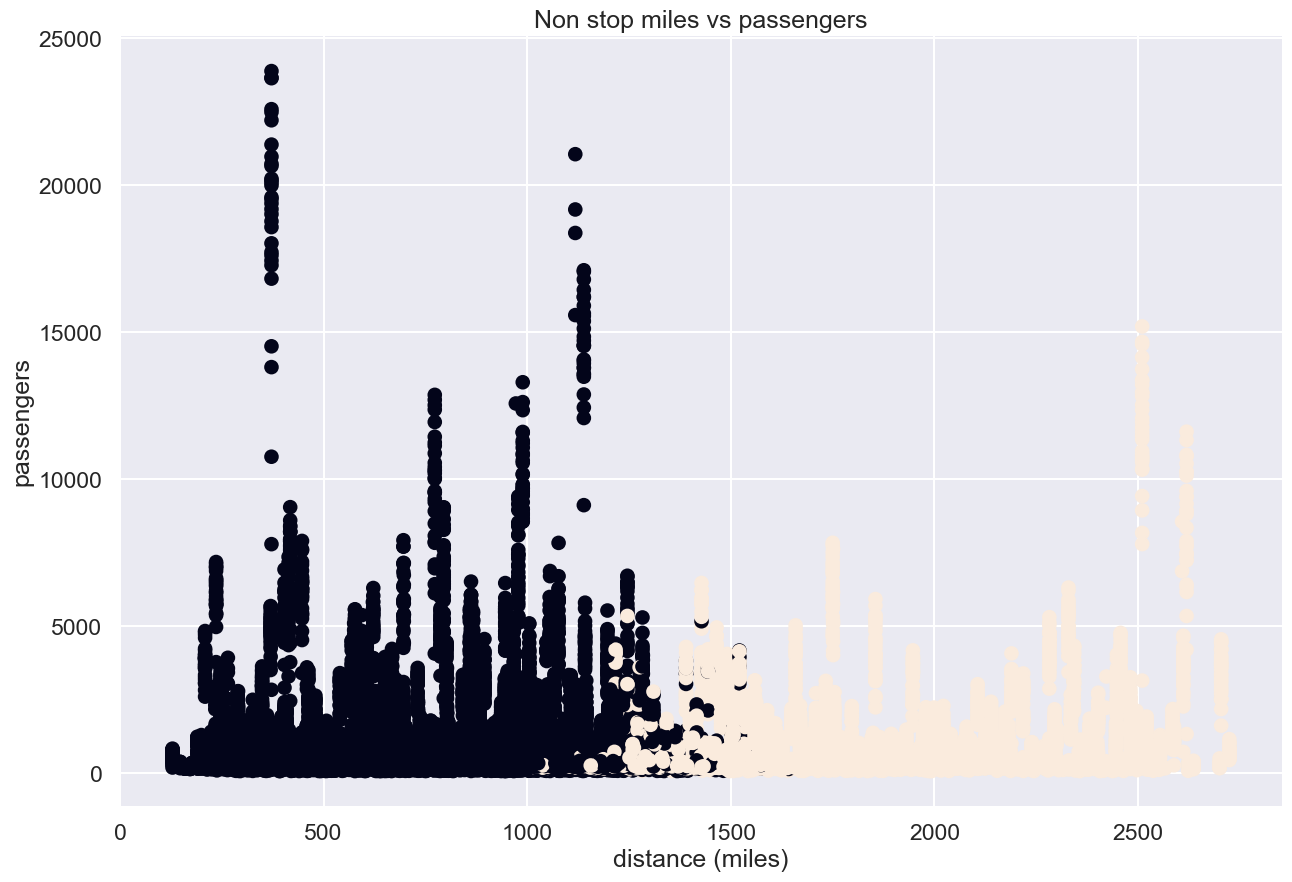

In [249]:
fig, ax = plt.subplots(figsize=(15, 10))

ax = ax.scatter(x=km_df["nsmiles"], y=km_df["passengers"], c=km_df["cluster"])
plt.title("Non stop miles vs passengers")
plt.xlabel("distance (miles)")
plt.ylabel("passengers")
fig.savefig(f"./{save_results_to}/km3milespass.png", dpi=300, transparent=True)

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

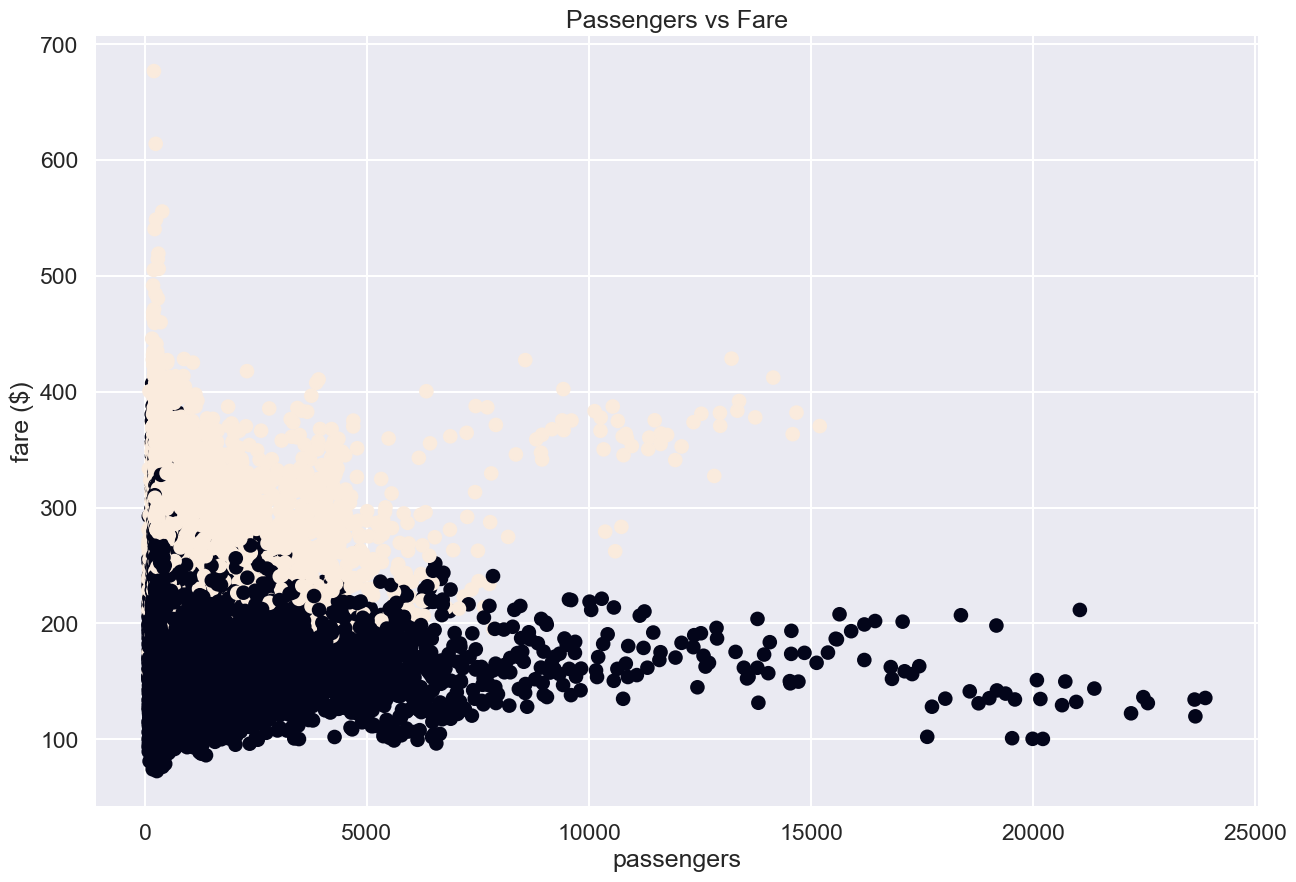

In [250]:
fig, ax = plt.subplots(figsize=(15, 10))

ax = ax.scatter(x=km_df["passengers"], y=km_df["fare"], c=km_df["cluster"])
plt.title("Passengers vs Fare")
plt.xlabel("passengers")
plt.ylabel("fare ($)")
fig.savefig(f"./{save_results_to}/km3passfare.png", dpi=300, transparent=True)

plt.show

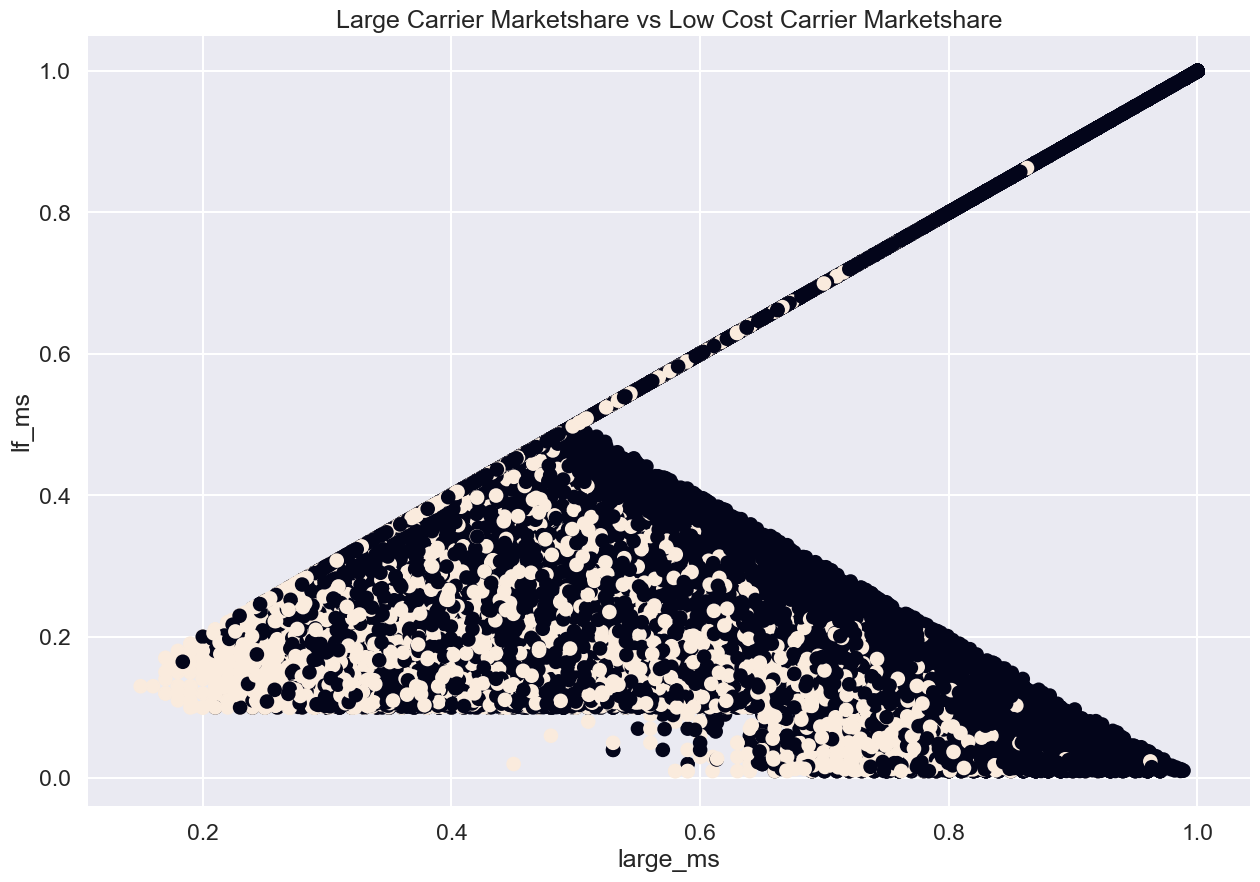

In [251]:
fig, ax = plt.subplots(figsize=(15, 10))

ax = ax.scatter(x=km_df["large_ms"], y=km_df["lf_ms"], c=km_df["cluster"])

plt.title("Large Carrier Marketshare vs Low Cost Carrier Marketshare")
plt.xlabel("large_ms")
plt.ylabel("lf_ms")
fig.savefig(f"./{save_results_to}/km3ms.png", dpi=300, transparent=True)

plt.show()

In [252]:
silhouette_avg = silhouette_score(X_noms, kmeans.labels_)
print(f"The average silhouette score is: {silhouette_avg}")

The average silhouette score is: 0.4897933628767886


In [253]:
db_score = davies_bouldin_score(X_noms, kmeans.labels_)
print(f"The Davies-Bouldin score is: {db_score}")

The Davies-Bouldin score is: 0.797307522739757


In [254]:
kmeans = KMeans(n_clusters=3)

In [255]:
kmeans.fit(X_noms)

KMeans(n_clusters=3)

In [256]:
km_df = cleaned_data.copy()
km_df["cluster"] = kmeans.labels_

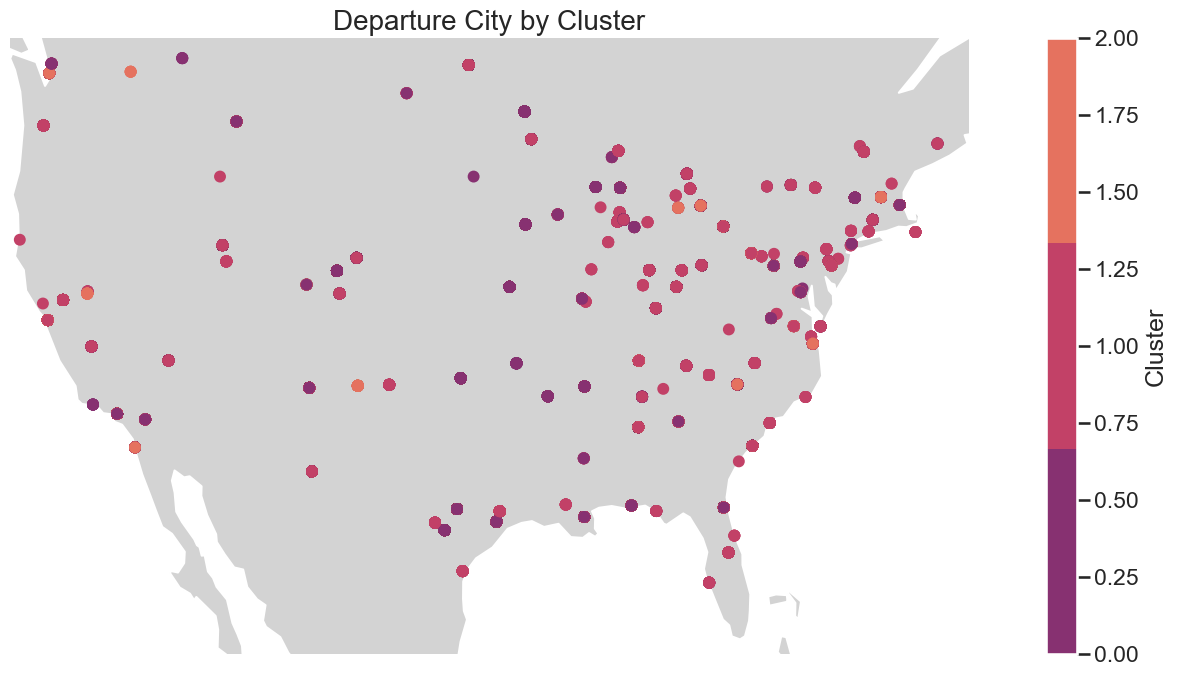

In [257]:
city_gdf = gpd.GeoDataFrame(km_df, geometry=gpd.points_from_xy(km_df.city1_long, km_df.city1_lat), crs="EPSG:4326")
# Load data
world = gpd.read_file(get_path("naturalearth.land"))
# Assuming city_gdf is your GeoDataFrame with city data and cluster information

# Create a custom colormap using the Seaborn palette
n_clusters = city_gdf['cluster'].nunique()
colors = sns.color_palette(theme, n_colors=n_clusters)
cmap = LinearSegmentedColormap.from_list("custom", colors, N=n_clusters)

# Create the plot
fig, ax = plt.subplots(figsize=(20, 8))

# Plot the world map
world.plot(ax=ax, color='lightgrey', edgecolor='white')

# Plot cities with colors according to cluster
scatter = city_gdf.plot(ax=ax, column='cluster', cmap=cmap, 
                        markersize=50, marker='o', legend=True,
                        legend_kwds={'label': 'Cluster', 'orientation': 'vertical'})

# Define the bounding box for North America
xlim = (-124.7, -66.9)  # Longitude limits
ylim = (24.5, 49)  # Latitude limits

# Set the limits for North America
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_axis_off()  # Hides the axis

plt.title("Departure City by Cluster", fontsize=20)

# Adjust the legend position
leg = ax.get_legend()
fig.savefig(f"./{save_results_to}/km3-1city1cluster.png", dpi=300, transparent=True)
plt.show()

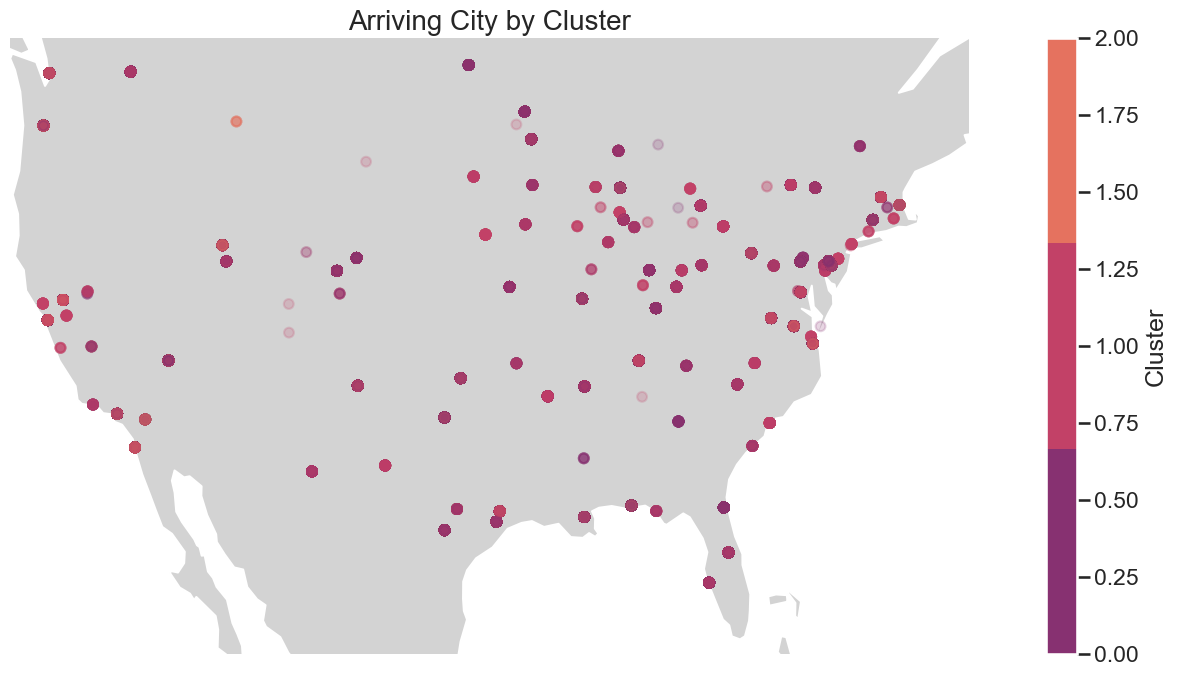

In [258]:
city_gdf = gpd.GeoDataFrame(km_df, geometry=gpd.points_from_xy(km_df.city2_long, km_df.city2_lat), crs="EPSG:4326")
# Load data
world = gpd.read_file(get_path("naturalearth.land"))
# Assuming city_gdf is your GeoDataFrame with city data and cluster information

# Create a custom colormap using the Seaborn palette
n_clusters = city_gdf['cluster'].nunique()
colors = sns.color_palette(theme, n_colors=n_clusters)
cmap = LinearSegmentedColormap.from_list("custom", colors, N=n_clusters)

# Create the plot
fig, ax = plt.subplots(figsize=(20, 8))

# Plot the world map
world.plot(ax=ax, color='lightgrey', edgecolor='white')

# Plot cities with colors according to cluster
scatter = city_gdf.plot(ax=ax, column='cluster', cmap=cmap, 
                        markersize=50, marker='o', legend=True,
                        legend_kwds={'label': 'Cluster', 'orientation': 'vertical'},
                        alpha=0.2)

# Define the bounding box for North America
xlim = (-124.7, -66.9)  # Longitude limits
ylim = (24.5, 49)  # Latitude limits

# Set the limits for North America
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_axis_off()  # Hides the axis

plt.title("Arriving City by Cluster", fontsize=20)

# Adjust the legend position
leg = ax.get_legend()
fig.savefig(f"./{save_results_to}/km3-1city2cluster.png", dpi=300, transparent=True)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

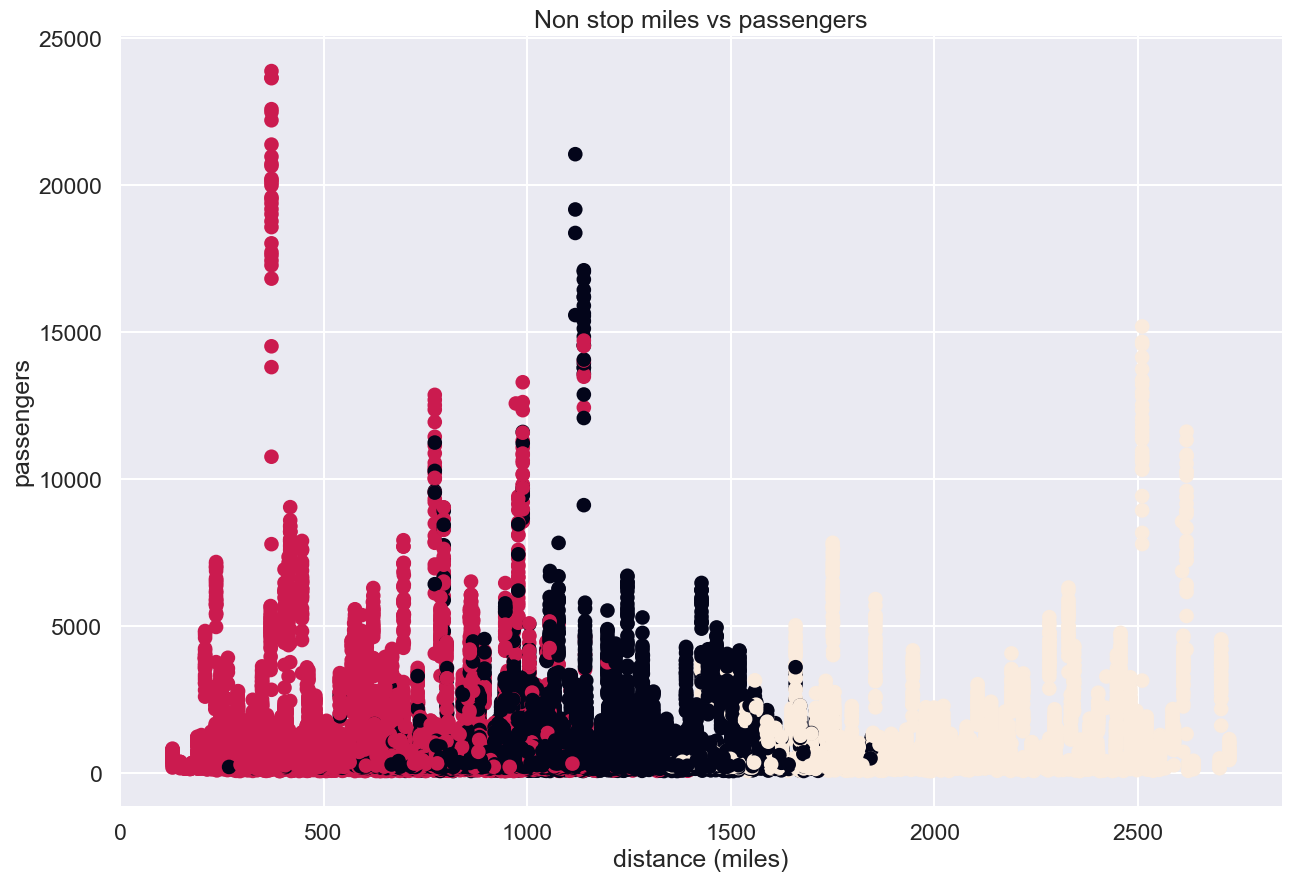

In [259]:
fig, ax = plt.subplots(figsize=(15, 10))

ax = ax.scatter(x=km_df["nsmiles"], y=km_df["passengers"], c=km_df["cluster"])
plt.title("Non stop miles vs passengers")
plt.xlabel("distance (miles)")
plt.ylabel("passengers")
fig.savefig(f"./{save_results_to}/km3-1milespass.png", dpi=300, transparent=True)

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

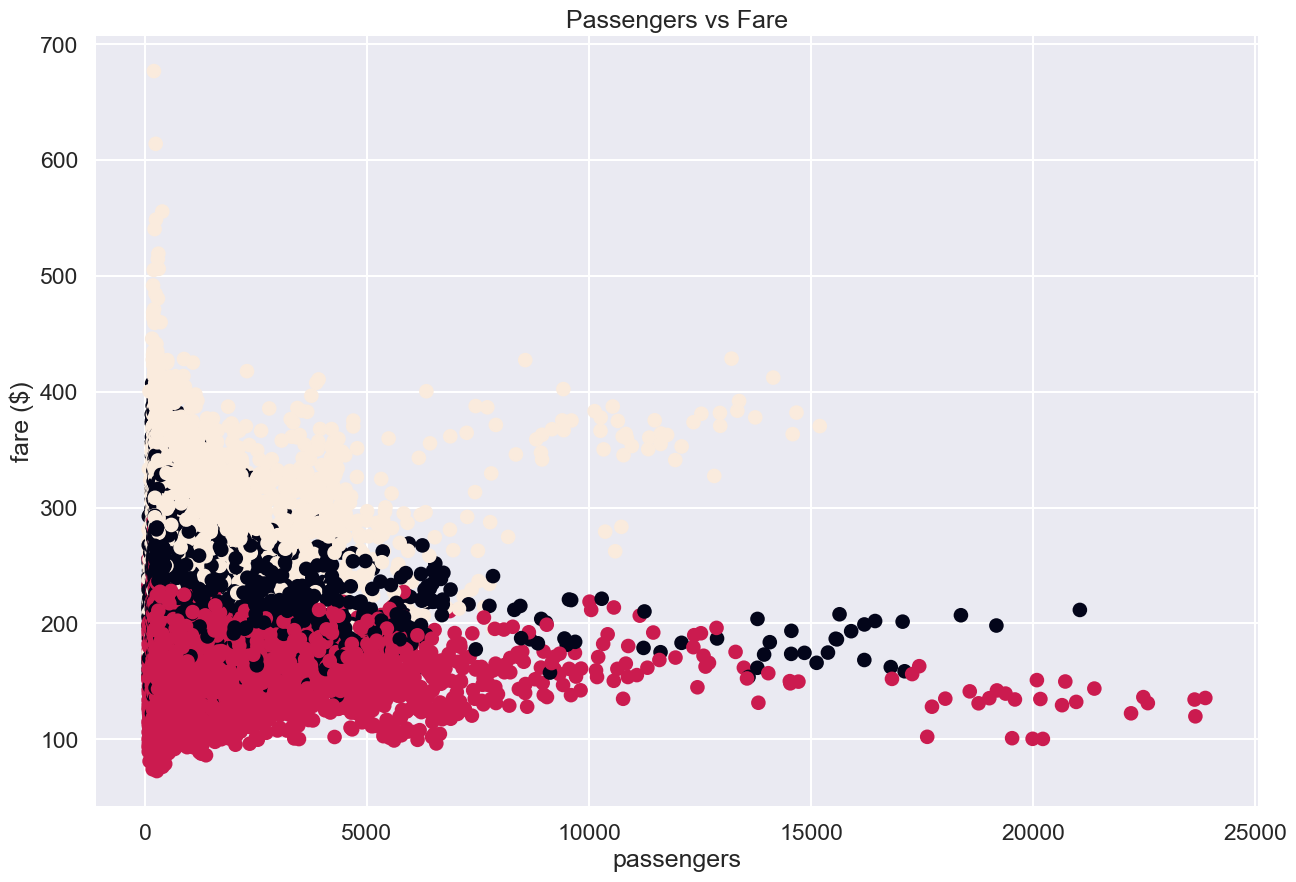

In [260]:
fig, ax = plt.subplots(figsize=(15, 10))

ax = ax.scatter(x=km_df["passengers"], y=km_df["fare"], c=km_df["cluster"])
plt.title("Passengers vs Fare")
plt.xlabel("passengers")
plt.ylabel("fare ($)")
fig.savefig(f"./{save_results_to}/km3-1passfare.png", dpi=300, transparent=True)

plt.show

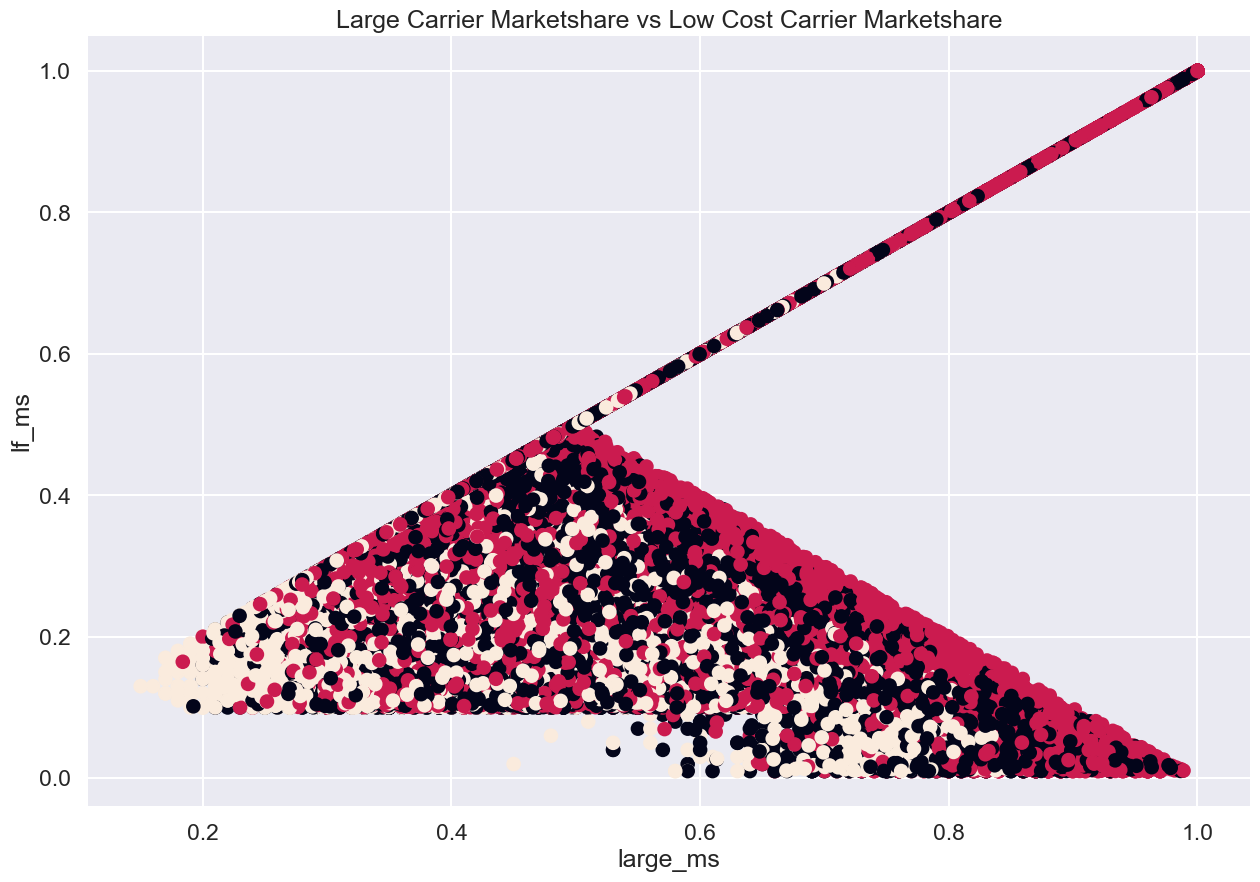

In [261]:
fig, ax = plt.subplots(figsize=(15, 10))

ax = ax.scatter(x=km_df["large_ms"], y=km_df["lf_ms"], c=km_df["cluster"])

plt.title("Large Carrier Marketshare vs Low Cost Carrier Marketshare")
plt.xlabel("large_ms")
plt.ylabel("lf_ms")
fig.savefig(f"./{save_results_to}/km3-1ms.png", dpi=300, transparent=True)

plt.show()

In [262]:
silhouette_avg = silhouette_score(X_noms, kmeans.labels_)
print(f"The average silhouette score is: {silhouette_avg}")

The average silhouette score is: 0.32238207207898467


In [263]:
db_score = davies_bouldin_score(X_noms, kmeans.labels_)
print(f"The Davies-Bouldin score is: {db_score}")

The Davies-Bouldin score is: 1.1109552052058145


### Agg2 Cluster using Coordinates Only

In [264]:
coords_only = cleaned_data.drop(cleaned_data.columns.difference(["city1_lat", "city1_long", "city2_lat", "city2_long"]), axis=1)
coords_only


city1_lat  city1_long  city2_lat  city2_long
0      44.977479  -93.264346  43.155708  -77.612547
1      36.169202 -115.140597  44.977479  -93.264346
2      38.256078  -85.751569  37.860600  -78.804199
3      41.775002  -87.696388  37.540759  -77.433932
4      44.977479  -93.264346  32.715760 -117.163817
...          ...         ...        ...         ...
31990  35.962631  -83.916677  38.892062  -77.019912
31991  35.962631  -83.916677  40.123164  -75.333718
31992  35.962631  -83.916677  44.977479  -93.264346
31993  35.962631  -83.916677  37.860600  -78.804199
31994  35.962631  -83.916677  37.780080 -122.420168

[31995 rows x 4 columns]

In [285]:
agg = AgglomerativeClustering(n_clusters=4, compute_distances=True)

In [286]:
agg.fit(coords_only)

AgglomerativeClustering(compute_distances=True, n_clusters=4)

In [287]:
agg.n_clusters_

4

<function matplotlib.pyplot.show(close=None, block=None)>

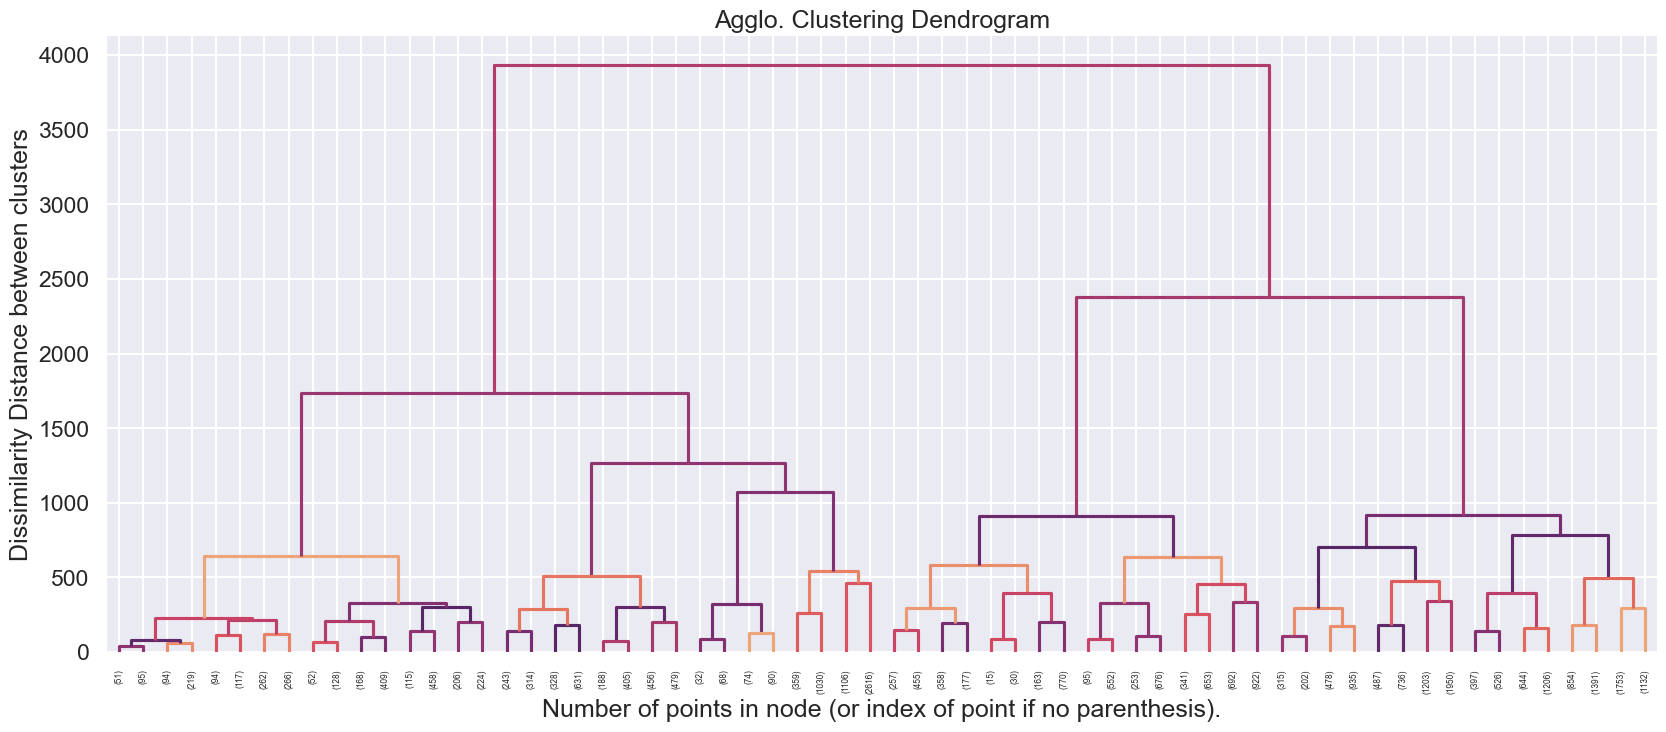

In [288]:
fig, ax = plt.subplots(figsize=(20, 8))

hex_colors = [mcolors.to_hex(color) for color in palette]
ax = plot_dendrogram(agg, link_color_func=lambda k: hex_colors[k % num_colors], truncate_mode="level", p=5)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.ylabel("Dissimilarity Distance between clusters")
plt.title("Agglo. Clustering Dendrogram")
fig.savefig(f"./{save_results_to}/agg2dendro.png", dpi=300, transparent=True)

plt.show

In [289]:
agg_df = cleaned_data.copy()
agg_df["cluster"] = agg.labels_

In [290]:
city_gdf = gpd.GeoDataFrame(agg_df, geometry=gpd.points_from_xy(agg_df.city1_long, agg_df.city1_lat), crs="EPSG:4326")

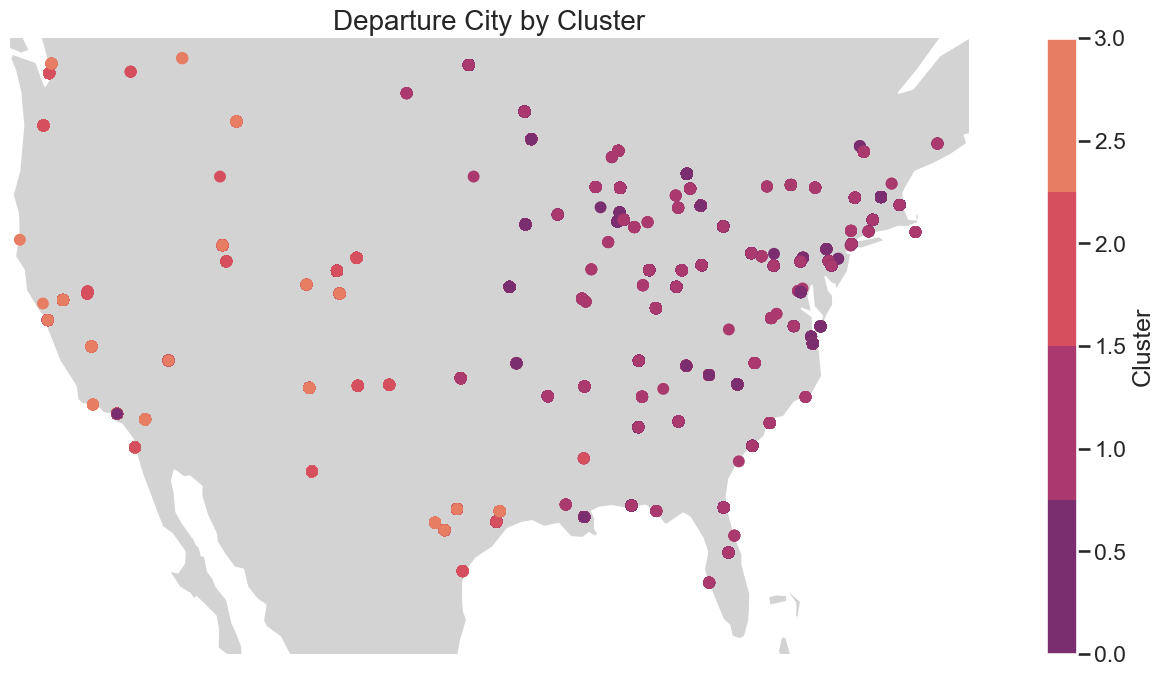

In [291]:
# Load data
world = gpd.read_file(get_path("naturalearth.land"))
# Assuming city_gdf is your GeoDataFrame with city data and cluster information

# Create a custom colormap using the Seaborn palette
n_clusters = city_gdf['cluster'].nunique()
colors = sns.color_palette(theme, n_colors=n_clusters)
cmap = LinearSegmentedColormap.from_list("custom", colors, N=n_clusters)

# Create the plot
fig, ax = plt.subplots(figsize=(20, 8))

# Plot the world map
world.plot(ax=ax, color='lightgrey', edgecolor='white')

# Plot cities with colors according to cluster
scatter = city_gdf.plot(ax=ax, column='cluster', cmap=cmap, 
                        markersize=50, marker='o', legend=True,
                        legend_kwds={'label': 'Cluster', 'orientation': 'vertical'})

# Define the bounding box for North America
xlim = (-124.7, -66.9)  # Longitude limits
ylim = (24.5, 49)  # Latitude limits


# Set the limits for North America
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_axis_off()  # Hides the axis

plt.title("Departure City by Cluster", fontsize=20)

# Adjust the legend position
leg = ax.get_legend()
fig.savefig(f"./{save_results_to}/agg2city1cluster.png", dpi=300, transparent=True)
plt.show()

In [292]:
city_gdf = gpd.GeoDataFrame(agg_df, geometry=gpd.points_from_xy(agg_df.city2_long, agg_df.city2_lat), crs="EPSG:4326")

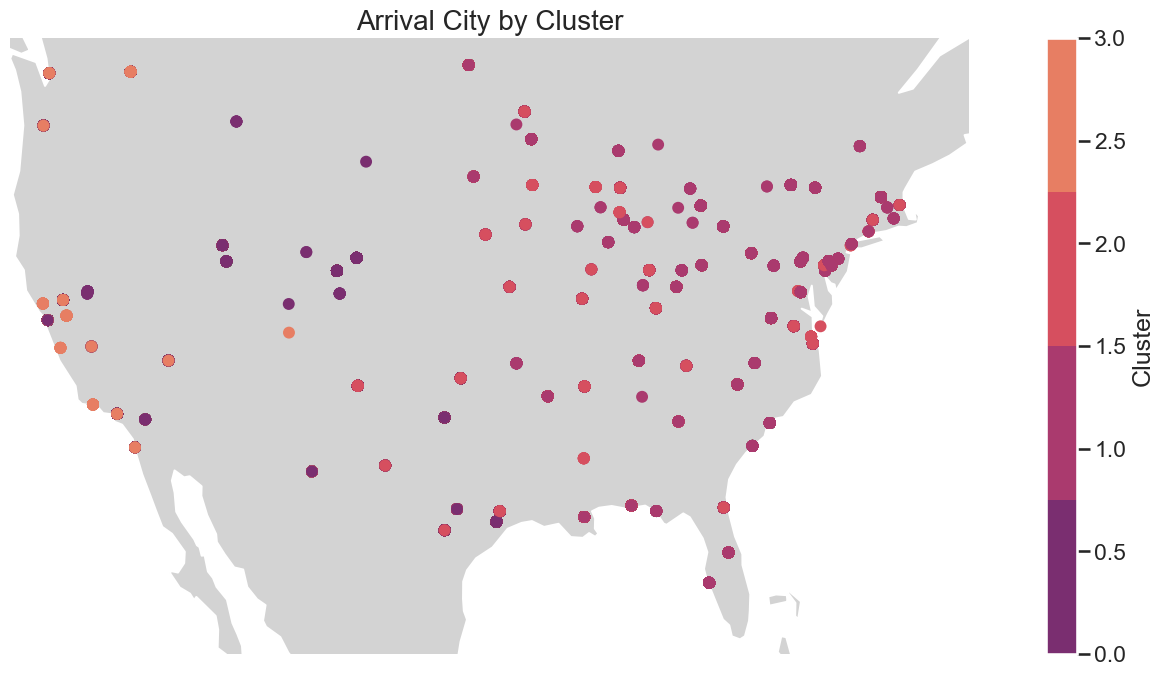

In [293]:
# Load data
world = gpd.read_file(get_path("naturalearth.land"))
# Assuming city_gdf is your GeoDataFrame with city data and cluster information

# Create a custom colormap using the Seaborn palette
n_clusters = city_gdf['cluster'].nunique()
colors = sns.color_palette(theme, n_colors=n_clusters)
cmap = LinearSegmentedColormap.from_list("custom", colors, N=n_clusters)

# Create the plot
fig, ax = plt.subplots(figsize=(20, 8))

# Plot the world map
world.plot(ax=ax, color='lightgrey', edgecolor='white')

# Plot cities with colors according to cluster
scatter = city_gdf.plot(ax=ax, column='cluster', cmap=cmap, 
                        markersize=50, marker='o', legend=True,
                        legend_kwds={'label': 'Cluster', 'orientation': 'vertical'})

# Define the bounding box for North America
xlim = (-124.7, -66.9)  # Longitude limits
ylim = (24.5, 49)  # Latitude limits

# Set the limits for North America
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_axis_off()  # Hides the axis

plt.title("Arrival City by Cluster", fontsize=20)

# Adjust the legend position
leg = ax.get_legend()
fig.savefig(f"./{save_results_to}/agg2city2cluster.png", dpi=300, transparent=True)
plt.show()

In [294]:
silhouette_avg = silhouette_score(coords_only, agg.labels_)
print(f"The average silhouette score is: {silhouette_avg}")

The average silhouette score is: 0.36295965705198735


In [295]:
db_score = davies_bouldin_score(coords_only, agg.labels_)
print(f"The Davies-Bouldin score is: {db_score}")

The Davies-Bouldin score is: 0.9915806024341887


### KMeans4 Cluster using Coordinates Only

In [276]:
kmeans = KMeans(n_clusters=4)

In [277]:
kmeans.fit(coords_only)

KMeans(n_clusters=4)

In [278]:
km_df = cleaned_data.copy()
km_df["cluster"] = kmeans.labels_

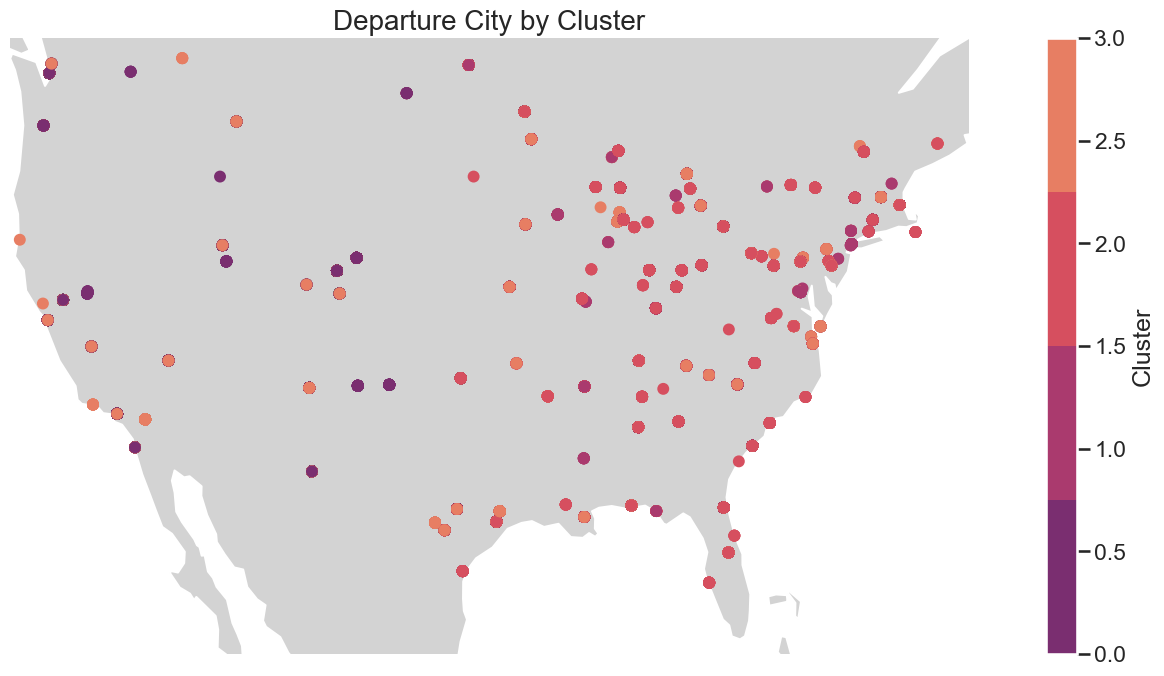

In [279]:
city_gdf = gpd.GeoDataFrame(km_df, geometry=gpd.points_from_xy(km_df.city1_long, km_df.city1_lat), crs="EPSG:4326")
# Load data
world = gpd.read_file(get_path("naturalearth.land"))
# Assuming city_gdf is your GeoDataFrame with city data and cluster information

# Create a custom colormap using the Seaborn palette
n_clusters = city_gdf['cluster'].nunique()
colors = sns.color_palette(theme, n_colors=n_clusters)
cmap = LinearSegmentedColormap.from_list("custom", colors, N=n_clusters)

# Create the plot
fig, ax = plt.subplots(figsize=(20, 8))

# Plot the world map
world.plot(ax=ax, color='lightgrey', edgecolor='white')

# Plot cities with colors according to cluster
scatter = city_gdf.plot(ax=ax, column='cluster', cmap=cmap, 
                        markersize=50, marker='o', legend=True,
                        legend_kwds={'label': 'Cluster', 'orientation': 'vertical'})

# Define the bounding box for North America
xlim = (-124.7, -66.9)  # Longitude limits
ylim = (24.5, 49)  # Latitude limits

# Set the limits for North America
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_axis_off()  # Hides the axis

plt.title("Departure City by Cluster", fontsize=20)

# Adjust the legend position
leg = ax.get_legend()
fig.savefig(f"./{save_results_to}/km4city1cluster.png", dpi=300, transparent=True)
plt.show()

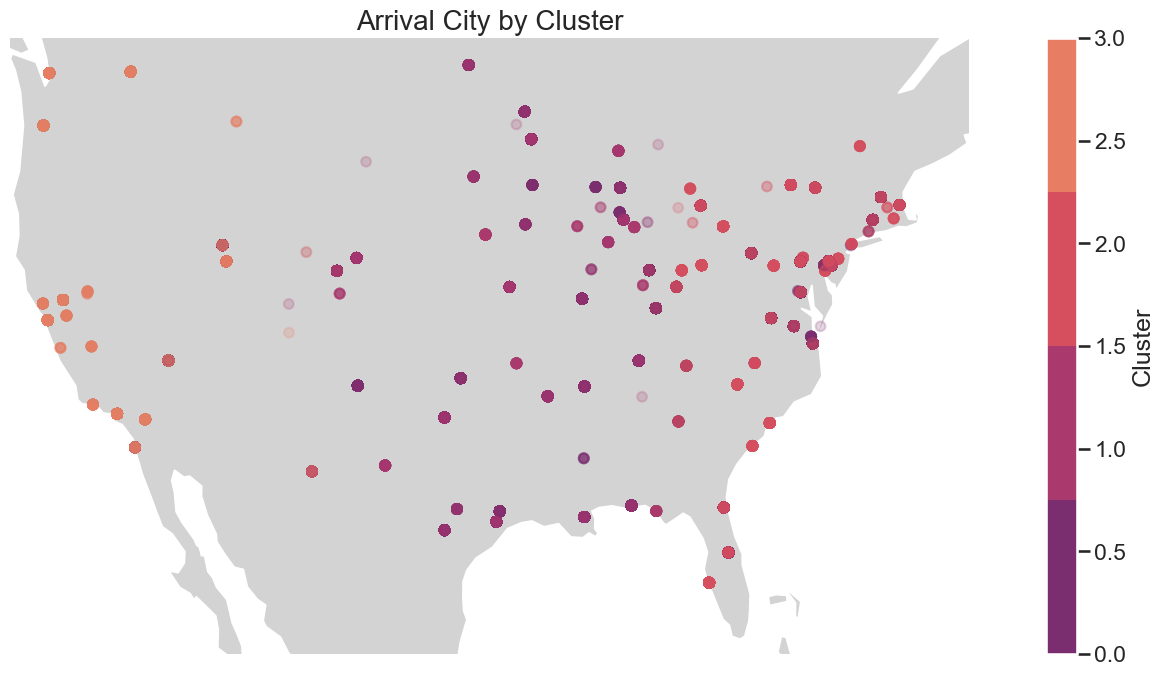

In [280]:
city_gdf = gpd.GeoDataFrame(km_df, geometry=gpd.points_from_xy(km_df.city2_long, km_df.city2_lat), crs="EPSG:4326")
# Load data
world = gpd.read_file(get_path("naturalearth.land"))
# Assuming city_gdf is your GeoDataFrame with city data and cluster information

# Create a custom colormap using the Seaborn palette
n_clusters = city_gdf['cluster'].nunique()
colors = sns.color_palette(theme, n_colors=n_clusters)
cmap = LinearSegmentedColormap.from_list("custom", colors, N=n_clusters)

# Create the plot
fig, ax = plt.subplots(figsize=(20, 8))

# Plot the world map
world.plot(ax=ax, color='lightgrey', edgecolor='white')

# Plot cities with colors according to cluster
scatter = city_gdf.plot(ax=ax, column='cluster', cmap=cmap, 
                        markersize=50, marker='o', legend=True,
                        legend_kwds={'label': 'Cluster', 'orientation': 'vertical'},
                        alpha=0.2)

# Define the bounding box for North America
xlim = (-124.7, -66.9)  # Longitude limits
ylim = (24.5, 49)  # Latitude limits

# Set the limits for North America
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_axis_off()  # Hides the axis

plt.title("Arrival City by Cluster", fontsize=20)

# Adjust the legend position
leg = ax.get_legend()
fig.savefig(f"./{save_results_to}/km4city2cluster.png", dpi=300, transparent=True)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

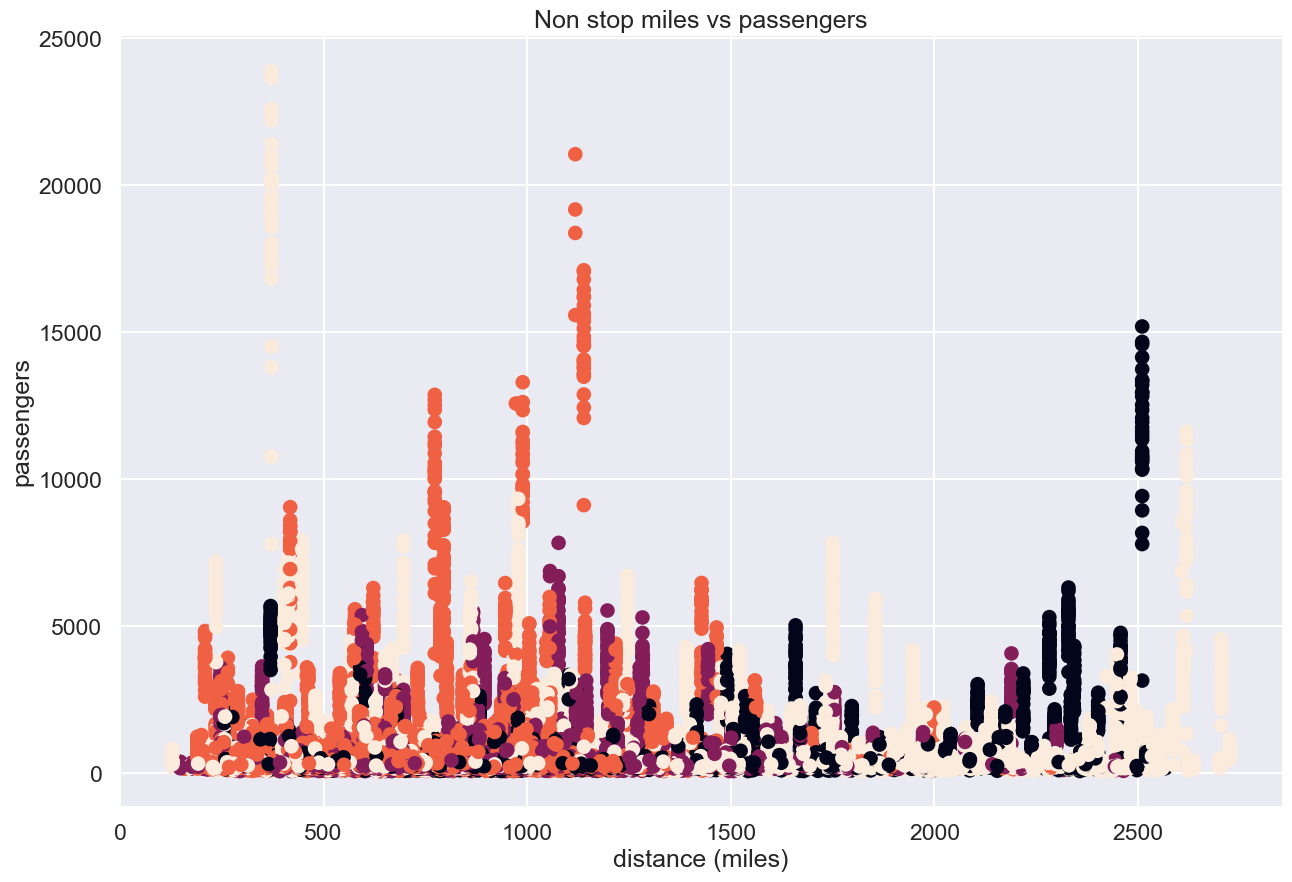

In [281]:
fig, ax = plt.subplots(figsize=(15, 10))

ax = ax.scatter(x=km_df["nsmiles"], y=km_df["passengers"], c=km_df["cluster"])
plt.title("Non stop miles vs passengers")
plt.xlabel("distance (miles)")
plt.ylabel("passengers")
fig.savefig(f"./{save_results_to}/km4milespass.png", dpi=300, transparent=True)

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

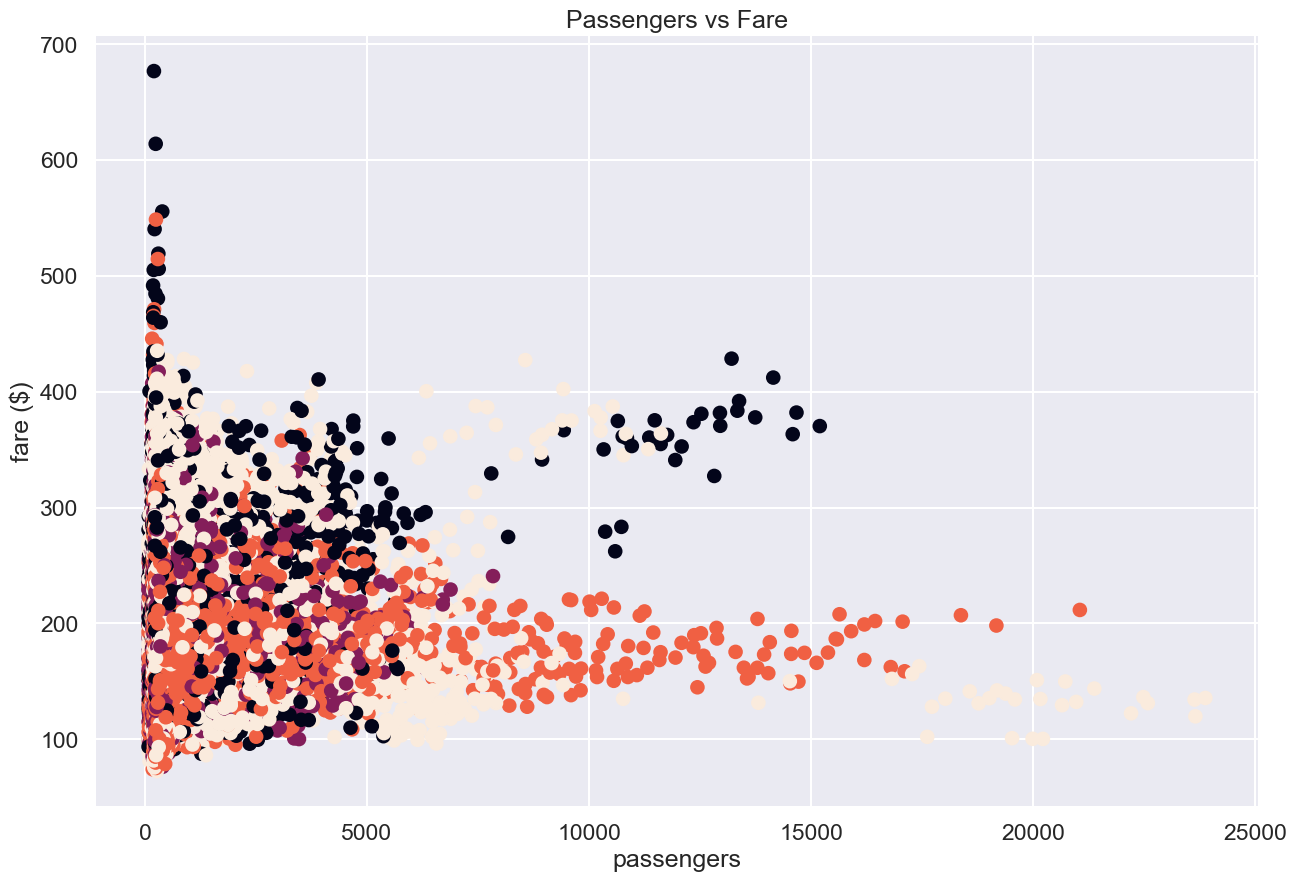

In [282]:
fig, ax = plt.subplots(figsize=(15, 10))

ax = ax.scatter(x=km_df["passengers"], y=km_df["fare"], c=km_df["cluster"])
plt.title("Passengers vs Fare")
plt.xlabel("passengers")
plt.ylabel("fare ($)")
fig.savefig(f"./{save_results_to}/km4passfare.png", dpi=300, transparent=True)
plt.show

In [283]:
silhouette_avg = silhouette_score(coords_only, kmeans.labels_)
print(f"The average silhouette score is: {silhouette_avg}")

The average silhouette score is: 0.31137305419568534


In [284]:
db_score = davies_bouldin_score(coords_only, kmeans.labels_)
print(f"The Davies-Bouldin score is: {db_score}")

The Davies-Bouldin score is: 1.12160533329283
